# Simulating irradiation stability of 2D materials

**Lab course**: Modern Methods in Material Physics, WS 2023

**Names**: Josef Hackl, Maximilian Negedly <br/>
**Supervisor**: Toma Susi <br/>
**Date**: 12.02. - 16.02.2024

## Introduction

In this experiment, we use different interatomic potentials to simulate the behaviour of a single-layer graphene lattice after a transfer of kinetic energy to an atom in the lattice, as would be the case in an electron microscope. We test this in the static-lattice approximation as well as for lattices undergoing thermal vibrations corresponding to different temperatures. In the latter case, we obtain statistical distributions of threshold energies for different temperatures that we analyze. Furthermore, we discuss the behaviour and compare the performance of the different potentials employed.

## Theoretical background

A solid with a crystalline structure that only consists of a single layer of atoms is referred to as a 2D material. Today, various 2D materials with varying properties are studied, the most famous one being graphene, which consists of carbon atoms and has a hexagonal lattice structure with basis vectors

$$\vec{a}_1 = a \cdot \begin{pmatrix}\frac{\sqrt{3}}{2} \\ \frac{1}{2}\end{pmatrix} \qquad \vec{a}_2 = a \cdot \begin{pmatrix}-\frac{\sqrt{3}}{2} \\ \frac{1}{2}\end{pmatrix}$$

and lattice constant $a = 2.46$ Å [1].

In recent years, Scanning Transmission Electron Microscopy (STEM) has become a valueable tool for studying 2D materials. In contrast to (traditional) light microscopes, STEM devices use a focussed beam of electrons that is scanned over a sample in order to form an image. Since the de Broglie wavelength of electrons at relativistic velocities typically found in electron microscopes is orders of magnitude smaller than the wavelength of visible light, far better resulutions are possible through this technique. With the continuing development and improvement of aberration correctors, even higher resolutions are possible while at the same time reducing the necessary electron beam energy. [2]

### Irradiation damage and displacement threshold energy

Relativistic electrons in electron microscopes carry high kinetic energies. Therefore, when scattered with a sample, they are sometimes able to cause defects to form in said lattice through different machanisms such as elastic and inelastic scattering or chemical etching. [2]

In this experiment, we study pristine graphene, which is most dominantly affected by elastic scattering. When an electron scatters elastically with an atom, it transfers some of its kinetic energy to the atom. In this process, kinetic energy and momentum are conserved. If the transferred energy was high enough, the atom is ejected from the lattice. The minimum energy required for this to happen is called the displacement threshold energy $E_{KO}$. [2]

### Thermal vibrations

In the simplified case where the target atoms are at rest (static-lattice approximation), no damage is observed below $E_{KO}$, since the energy is then not high enough to cause the breaking of bonds and therefore the ejection of an atom. Above $E_{KO}$, every scattering process then leads to the ejection of an atom.

In reality however, the target atoms are not at rest due to thermal and quantum mechanical zero-point vibrations. Depending on the out-of-plane velocity of the target atom during the scattering process, it is both possible for the transferred energy to be above $E_{KO}$ but the atom to remain bound and for it to be below the threshold energy and the atom to be ejected [2]. Therefore, instead of a sharp increase in the ejection probability like in the static-lattice approximation, we expect the probability to rise smoothly with increasing electron beam energy. This results in a probability distribution for damage to occur that is sampled each time an electron is scattered on the sample.

## Methods and Results

In the following, the process of testing the different potentials on both static-lattice and thermalized systems is shown in a step-by-step way, each step briefly described and immediately followed by the results it produced.

### Packages used

In [1]:
import ase.units as units
from ase import Atoms
from ase.build import graphene
from ase.io import Trajectory
from ase.md.verlet import VelocityVerlet
from ase.visualize import view
from ase.calculators import calculator
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.langevin import Langevin

from quippy.potential import Potential
from ase.calculators.kim.kim import KIM
from pyace import PyACECalculator

import time

from matplotlib import pyplot as plt

import numpy as np
import scipy as sc

import re

### Preparation of the system

For preparing the systems that will be simulated, we implement two functions:
- `get_middle()` for retrieving the index of the atom in the approximate center of the grid produced by `ASE`
- `get_atoms()` for actually generating a grid of given size with some vacuum above and below. Here, `ASE` provides a built-in function to automatically generate the lattice structure of graphene with the correct parameters for its atoms.

It is also important to note that we impose periodic boundary conditions for which we will perform tests in order to avoid finite-size effects.

In [2]:
def get_middle(atoms : Atoms) -> int:
    """
    For a given atoms list, returns the index of the center atom.

    Parameters
    ----------
    atoms : ase.Atoms
        The atoms array to get the dimensions from

    Returns
    -------
    middle_atom : int
        Index of the center atom
    """
    middle_atoms = {7: 49, 6: 42, 5: 25, 4: 20, 3: 9, 2: 6, 1: 1}
    return middle_atoms[int(np.sqrt(len(atoms)/2))]

In [3]:
def get_atoms(size : tuple) -> Atoms:
    """
    Returns a graphene lattice of dimensions size and with a vacuum layer of 10 on
    each side of the lattice

    Parameters
    ----------
    size : tuple
        The dimensions of the lattice to create (in units of unit cells)

    Returns
    -------
    gra : ase.Atoms
        The generated lattice
    """
    a = 2.45
    gra = graphene(a=a, size=size, vacuum=10)

    gra.center()
    
    gra.pbc = (True, True, True)

    return gra

### Simulation code for static-lattice ejection simulations

`ASE` equips us with some very powerful tools to perform MD simulations. The main ideas are that we provide it with a propagation algorithm, a file name to which the trajectory of the simulation will be saved and a timestep and it then allows us to perform an arbitrary amount of simulation steps.

The function `run_simulation()` below is a wrapper for the `ASE` propagator that not only propagates the system but also gives the middle atom an initial momentum kick corresponding to the kinetic energy `ekin` specified. While propagating the system, the function then periodically checks whether it thinks that the kicked atom was ejected or whether it returned to the lattice. This is done through a simple algorithm: If the atom's momentum is reversed, we know that the attracting force was great enough (i.e., the kinetic energy was small enough) to cause the atom to not be ejected. This part is fairly straightforward and there is no chance of incorrectly detecting an atom as not ejected.

The tricky part however is to detect whether the atom was ejected or not, since, as long as there is a force, we do not know whether it will be great enough to cause the atom to eventually return to the lattice. The way this was implemented is that we periodically check the relative change of momentum of the atom from one timestep to the other. If this change drops below a certain threshold, we label the atom as ejected.

This algorithm is not particularly trustworthy, since the threshold value must be found empirically and changes with parameters such as cell size and timestep. It is therefore always better to let the simulation run a certain number of timesteps until we are sure that the atom either returns or not. Choosing a threshold that is too small results in non-ejected atoms to be labeled as ejected and prematurely ending the simulation. However, for doing many simulations in order to optimize parameters, it is necessary to impose this restriction, since we cannot afford to let every simulation run until the end.

For the static-lattice approximation, we use the velocity verlet algorithm to propagate the system in an NVE (constant number of particles N, volume V and total energy E) ensemble.

In [4]:
def run_simulation(atoms : Atoms, calc : calculator, ekin : float, n_timesteps : int, timestep : float, traj_file : str, check_ejected=True, printing=True, ejection_threshold=0.0001) -> str:
    """
    Performs n_timesteps of simulation steps using the specified calculator calc and writes
    trajectories to the file traj_file. Uses timestep in fs and kicks the center
    atom of the atoms array with a kinetic energy ekin. If check_ejected is true, the function
    will automatically try to determine whether the atom has been ejected or whether it returns to
    the lattice, the latter with perfect accuracy, the former based on the rate of change of
    momentum, which, for small timesteps, must be modified appropriately.

    Parameters
    ----------
    atoms : ase.Atoms
        The lattice to use for the simulation
    
    calc : ase.calculators.calculator
        The calculator to use

    ekin : float
        The kinetic energy in eV to kick the center atom with

    n_timesteps : int
        The number of simulation timesteps to perform (might be more or less depending on check_ejected)

    timestep : float
        The simulation timestep in fs

    traj_file : str
        The name of the simulation file to write the trajectory to

    check_ejected : bool
        Whether or not to check for atom ejection. If an atom is detected as either ejected or remained in the
        lattice, the simulation will stop and return the respective result

    printing : bool
        If True, prints status into console

    ejection_threshold : float
        Threshold percentage/100 value of momentum differential between two runs for labeling atom as ejected

    Returns
    -------
    result : str
        If check_ejected is True: ejected if the atom was ejected, not ejected if the atom was not ejected or
        unknown if neither condition was met
    """
    atoms.calc = calc
    
    # Integrator for the equations of motion, timestep depends on system
    dyn = VelocityVerlet(atoms, timestep * units.fs)

    momenta = []
    middle = get_middle(atoms)
    # Saving the positions of all atoms after every time step
    with Trajectory(traj_file, 'w', atoms) as traj:
        dyn.attach(traj.write, interval=1)
    
        # Running one timestep before impact
        dyn.run(1)
    
        # Giving the target atom a kinetic energy of ene in the -z direction
        atoms[middle].momentum[2] = -(2 * ekin * atoms[-1].mass)**0.5
        
        counter = 0 # Introduce a counter. If, after n_timesteps, the status is not determined, repeat the simulation a maximum of 2 times
        if not check_ejected:
            counter = 2
        while counter < 3:
            times = []
            for step in range(n_timesteps):
                start = time.time() # Measure time
                dyn.run(1) # Perform one simulation step
                times.append(time.time() - start) # Measure time
                momenta.append(atoms[middle].momentum[2]) # Save momentum for ejection check
                if not check_ejected:
                    # Continue loop if we do not check for ejection
                    continue
                if step > 10 and momenta[-1] > 0:
                    # Check for ejection by looking at the momentum of the atom. If it has inverted, we know it is returning to the lattice
                    # and was therefore not ejected
                    if printing:
                        print(f"[ekin={ekin:0.1f}] Atom definitely not ejected ({np.mean(times)*1000} ms/step).")
                    return "not ejected"
                if (step+1) % 10 == 0:
                    # Check for ejection. This part is tricky and one needs to be careful with the percentage in the if statement below
                    if momenta[-1] <= 0 and np.abs((momenta[-1] - momenta[-2])/momenta[-2]) < ejection_threshold:
                        if printing:
                            print(f"[ekin={ekin:0.1f}] Atom ejected ({np.mean(times)*1000} ms/step).")
                        return "ejected"
            counter += 1
            if check_ejected:
                if printing:
                    print(f"[ekin={ekin:0.1f}] No result, continuing simulation for another {n_timesteps} timesteps ({counter}/3)")
    return "unknown"

The next step is to load the different potentials we will later use to propagate the system and to determine quantities like potential energy or temperature.

In [5]:
gap = Potential('xml_label=GAP_2021_4_21_0_21_17_24_635', 
                param_filename='GAP/Carbon_GAP_V10_2_LDIter1_kptconsistent_grr6_2b_3b_soap_n12l4_sp9k_delta-2-0.05-0.1.xml',
                calc_args='local_gap_variance')
nn = KIM("hNN_WenTadmor_2019Grx_C__MO_421038499185_001")

tersoff = KIM("Tersoff_LAMMPS_Tersoff_1988_C__MO_579868029681_004")

pyace = PyACECalculator("PyACE/output_potential.yaml")
pyace.set_active_set("PyACE/output_potential.asi")

We are now ready to perform our simulations. There are two main parameters that we need to determine and that are different for each potential: The size of the system (measured in units of unit cells) and the timestep. Of course, we would like to choose values for those parameters that minimize computational effort whilst maintaining accuracy and convergence and avoiding finite-size effects.

For that, we employ the following procedure:
1. 

In [6]:
energies = np.arange(19, 19.5, 0.1)
timestep = 1.4
n_timesteps = 120
potential = "gap"
calc = eval(potential)
sizes = [(5, 5, 1)]

abort_on_ejected = False # Should the simulation for a specific cell size abort if ejection was detected for one of the energies

for size in sizes: # Loop through all sizes of grids
    print(f"\nDoing size {size}")
    ejected = False # If ejection was detected, cancel simulation for the current size (if abort_on_ejected is True)
    for ekin in energies:
        if ejected and abort_on_ejected:
            continue
        traj_file = f'trajectories_final_1/{potential}_{ekin:0.1f}.traj' # Load trajectory
        atoms = get_atoms(size) # Prepare grid with current size
        if run_simulation(atoms, calc, ekin, n_timesteps, timestep, traj_file, check_ejected=True) == "ejected":
            ejected = True
            


Doing size (5, 5, 1)
[ekin=19.0] Atom definitely not ejected (3647.409691810608 ms/step).
[ekin=19.1] Atom definitely not ejected (3591.797571629286 ms/step).
[ekin=19.2] No result, continuing simulation for another 120 timesteps (1/3)
[ekin=19.2] Atom ejected (2534.2091253825597 ms/step).
[ekin=19.3] No result, continuing simulation for another 120 timesteps (1/3)
[ekin=19.3] Atom ejected (2543.2268142700195 ms/step).
[ekin=19.4] Atom ejected (2516.101590069857 ms/step).


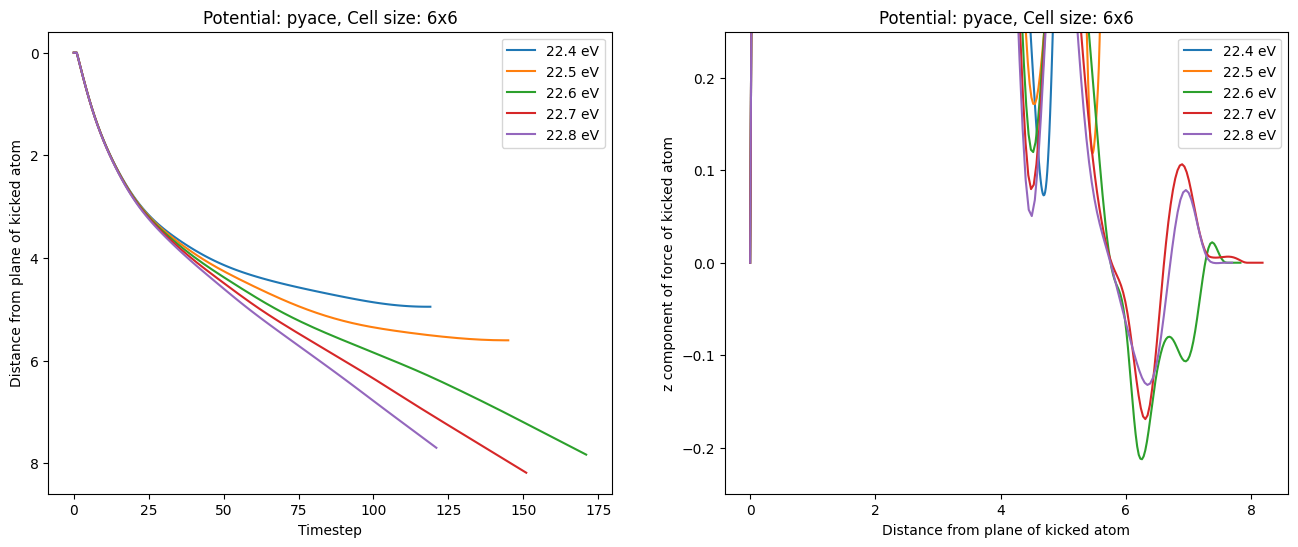

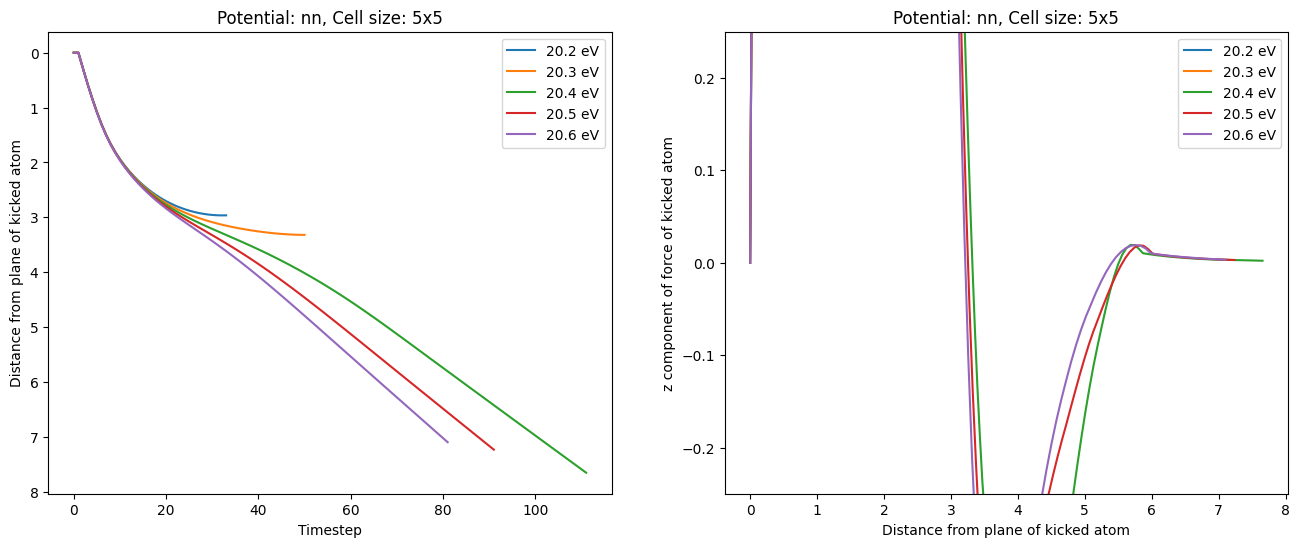

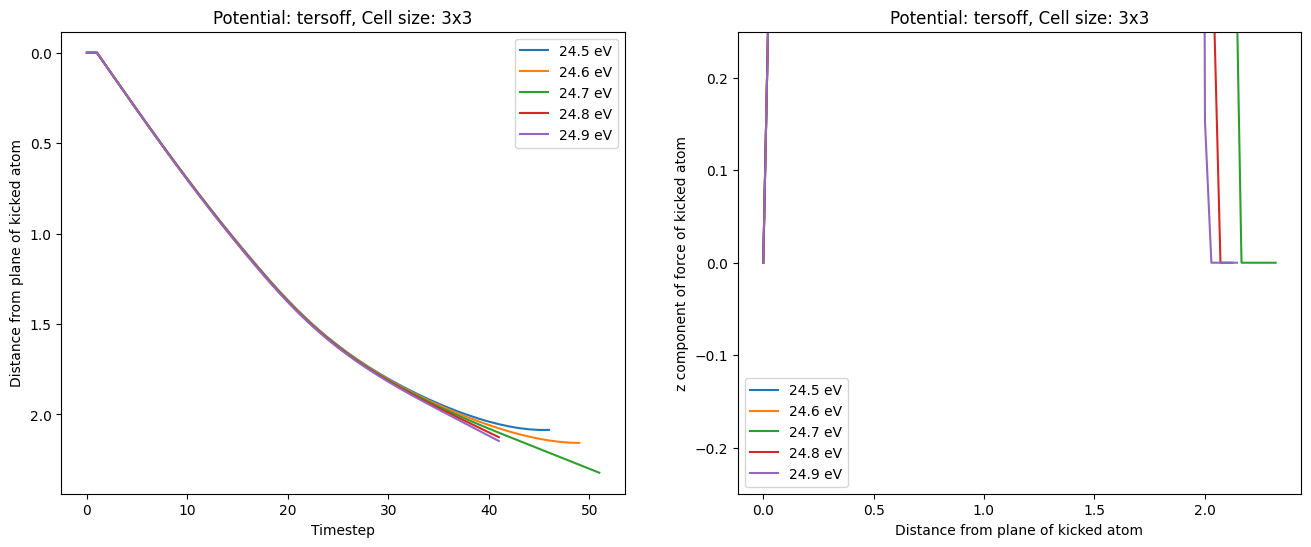

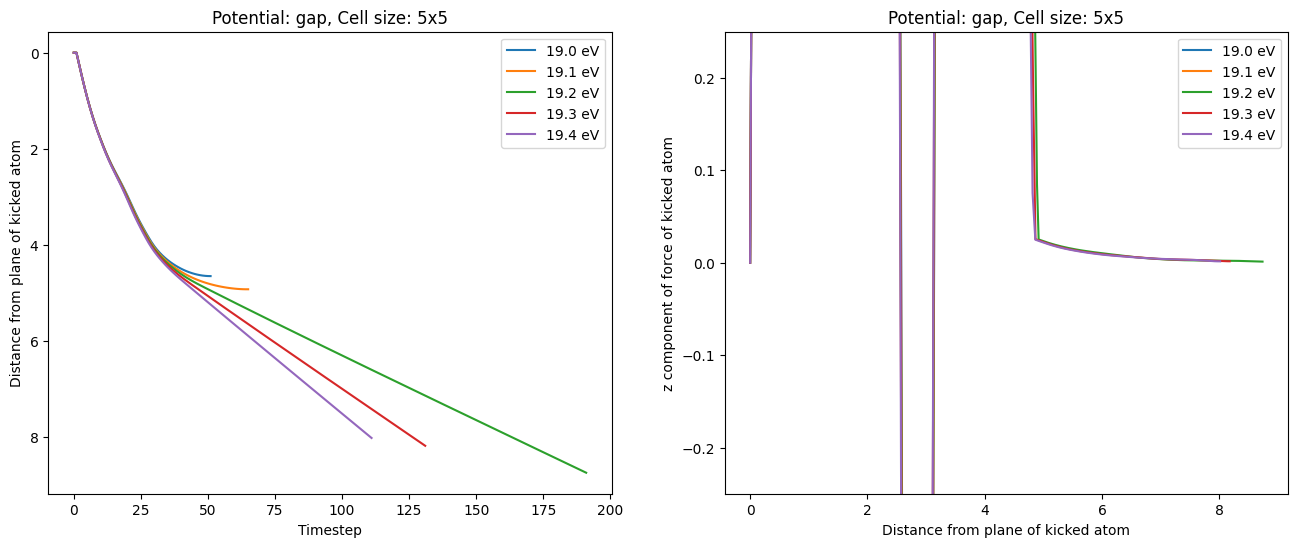

In [7]:
# Dictionary for plots. The keys are the potential names for which to look in the file system under trajectories_final_1/
# and the values are the energy ranges to look for.
potentials = {"pyace": np.arange(22.4, 22.8, 0.1), "nn": np.arange(20.2, 20.6, 0.1), "tersoff": np.arange(24.5, 25.0, 0.1), "gap": np.arange(19, 19.5, 0.1)}

for i, item in enumerate(potentials.items()):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    potential, energies = item

    positions = []
    forces = []
    for ekin in energies:
        traj = Trajectory(f"trajectories_final_1/{potential}_{ekin:0.1f}.traj") # Load trajectory for potential and kinetic energy

        middle = get_middle(traj[-1]) # Determine middle atom to know which atom to plot for
        cell_size = int(np.sqrt(len(traj[-1])/2)) # For plot title

        position = []
        force = []
        for j in range(len(traj)):
            position.append(traj[j][middle].position[2])
            force.append(traj[j].get_forces()[middle][2])
        positions.append(position)
        forces.append(force)

    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("Distance from plane of kicked atom")
    ax[0].set_title(f"Potential: {potential}, Cell size: {cell_size}x{cell_size}")

    ax[1].set_xlabel("Distance from plane of kicked atom")
    ax[1].set_ylabel("z component of force of kicked atom")
    ax[1].set_title(f"Potential: {potential}, Cell size: {cell_size}x{cell_size}")
    
    for j, position in enumerate(positions):
        ax[0].plot(np.abs(np.array(position)-10), label=f"{energies[j]:0.1f} eV") # Plot distance from plane vs. timestep in left plot
    
    for j in range(len(forces)):
        ax[1].plot(np.abs(np.array(positions[j])-10), forces[j], label=f"{energies[j]:0.1f} eV") # Plot force on kicked atom vs. distance from plane in right plot

    ax[0].legend()
    ax[1].legend()

    ax[0].invert_yaxis()
    ax[1].set_ylim(-0.25, 0.25)

    plt.show()

In [6]:
TIMESTEPS = {tersoff: 0.4, pyace: 1.2, nn: 1.6, gap: 1.4}
SIZES = {tersoff: (3, 3, 1), pyace: (6, 6, 1), nn: (5, 5, 1), gap: (5, 5, 1)}

In [7]:
def determine_scaling_factors(calcs : list) -> dict:
    """
    Determine the factors to scale cells with by relaxing internal pressure by minimizing
    the potential energy wrt. cell volume.

    Parameters:
    -----------
    calcs : list
        List of calculators to use for determining the potential energies

    Returns:
    --------
    scaling_factors : dict
        Dictionary where the keys are the calculators and the values are the corresponding scaling factors

    """
    factors = np.arange(0.8,1.2,0.001)
    atoms = get_atoms(size=(6, 6, 1))
    scaling_factors = {}

    for calc in calcs:
        energies = np.zeros(factors.size)

        for i, factor in enumerate(factors):
            atoms2 = atoms.copy()
            atoms2.set_cell(atoms.cell*factor, scale_atoms=True)
            atoms2.calc = calc
            energies[i] = atoms2.get_potential_energy()

        scaling_factors[calc] = factors[np.argmin(energies)]
    
    return scaling_factors

scaling_factors = determine_scaling_factors([tersoff, pyace, nn])

In [8]:
def generate_equilibrated_system(size : tuple, T : float, n_equilibration : int, timestep : float, calc : calculator, scaling_factors : dict, out_trajectory=False, NVT=False, filename=None) -> (Atoms, Trajectory):
    """
    Function that generates a graphene lattice, gives each atom a velocity drawn from a MB distribution
    and equilibrates the system

    Parameters
    ----------
    size : tuple
        The size of the graphene lattice in units of unit cells

    T : float
        The temperature in Kelvin used for the MB distribution

    n_equilibration : int
        Number of equilibration  timesteps to perform

    timestep : float
        Timestep to use for equilibration in fs

    calc : ase.calculators.calculator
        Calculator to use for equilibration

    scaling_factors : dict
        Dictionary with scaling factors for cell that contains the calculator used as a key

    out_trajectory : bool
        Whether or not to return the equilibration trajectory

    NVT : bool
        Equilibrate in NVT rather than in NVE ensemble

    filename : str
        Name of the trajectory file to write to. If none, use temporary file and return trajectory instead

    Returns
    -------
    gra : Atoms
        The equilibrated graphene lattice

    traj : Trajectory
        The equilibration trajectory, only returned if out_trajectory is True and no filename is given
    """
    gra = get_atoms(size)
    gra.set_cell(gra.cell*scaling_factors[calc], scale_atoms=True)
    gra.calc = calc

    if not NVT:
        MaxwellBoltzmannDistribution(gra, temperature_K=2*T) # Thermalize atoms. Use 2*T to get desired kinetic energies due to equipartition theorem
        Stationary(gra) # Move into center of mass reference frame
        
    if filename == None:
        filename = f"/tmp/traj_equil_{time.time()}.traj"
    traj = Trajectory(filename, "w", gra) if out_trajectory else None

    if NVT:
        Langevin(gra, timestep=timestep*units.fs, trajectory=traj, temperature_K=T, friction=0.01/units.fs).run(n_equilibration) # Equilibrate system in NVT ensemble
    else:
        VelocityVerlet(gra, timestep=timestep*units.fs, trajectory=traj).run(n_equilibration) # Equilibrate system in NVE ensemble

    if not traj == None:
        traj.close()

    if out_trajectory and filename.startswith("/tmp"):
        return gra, Trajectory(filename)
    return gra

def plot_temperature(traj : Trajectory, const=None) -> None:
    """
    Plot the temperature of a trajectory

    Parameters
    ----------
    traj : Trajectory
        The trajectory to plot the temperature from

    const : float
        Temperature to draw hline at
    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    temp = np.zeros(len(traj))
    for i in range(len(traj)):
        temp[i] = traj[i].get_temperature()
    
    if const != None:
        ax.hlines(const, 0, len(traj), ls="--", color="gray", label=f"T={const} K")
    ax.plot(temp, label="Simulation temperature")

    if const != None:
        ax.legend()

    ax.set_xlabel("Timestep")
    ax.set_ylabel("Temperature [K]")
    plt.show()

In [9]:
def propagate_system(atoms : Atoms, n_timestep : int, timestep : float, filename=None) -> None:
    """
    Propagate a system of atoms using Velocity Verlet

    Parameters
    ----------
    atoms : Atoms
        System to propagate
    
    n_timestep : int
        Number of timesteps to propagate for

    timestep : float
        Timestep in fs

    filename : str
        If not None, save the trajectory to a file
    """ 

    traj = Trajectory(filename, "w", atoms) if filename != None else None

    VelocityVerlet(atoms, timestep=timestep*units.fs, trajectory=traj).run(n_timestep) # Propagate system in NVE ensemble

    if not traj == None:
        traj.close()
    

In [10]:
def autocorrelate_momentum(traj : Trajectory) -> np.ndarray:
    """
    Compute the autocorrelation function for the z component of the momentum of the middle atom of the
    given trajectory

    Parameters
    ----------
    traj : Trajectory
        The trajectory to use

    Returns
    -------
    autocorrelation : np.ndarray
        The autocorrelation function values for the trajectory
    """

    
    middle = get_middle(traj[-1])
    M = len(traj)

    momenta = np.zeros(M)
    for i in range(M):
        momenta[i] = np.linalg.norm(traj[i][middle].momentum) # Store magnitude of the target atom's momentum

   
    momenta -= np.mean(momenta) # Remove com motion

    autocorrelation = np.correlate(momenta, momenta, mode="full")[-M:] / np.arange(M, 0, -1)
    autocorrelation /= np.std(momenta)**2 # normalization
       
    return autocorrelation

In [289]:
# Determining n_steps to simulate in order to avoid correlations, using large system size

autocorrelation_test_potentials = {"tersoff": tersoff, "pyace": pyace, "nn": nn}

for name, calc in autocorrelation_test_potentials.items():
    equil_test = generate_equilibrated_system(size=(6, 6, 1), T=300, n_equilibration=1000, timestep=TIMESTEPS[calc], calc=calc, scaling_factors=scaling_factors, out_trajectory=True, NVT=False, filename=f"trajectories_correlations/{name}.traj")


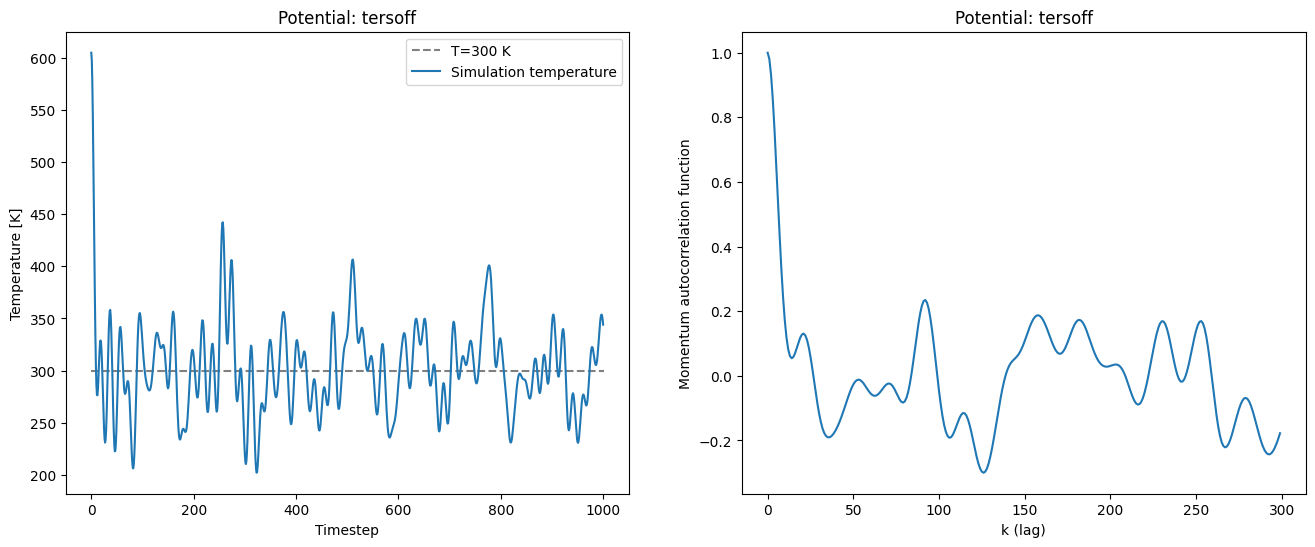

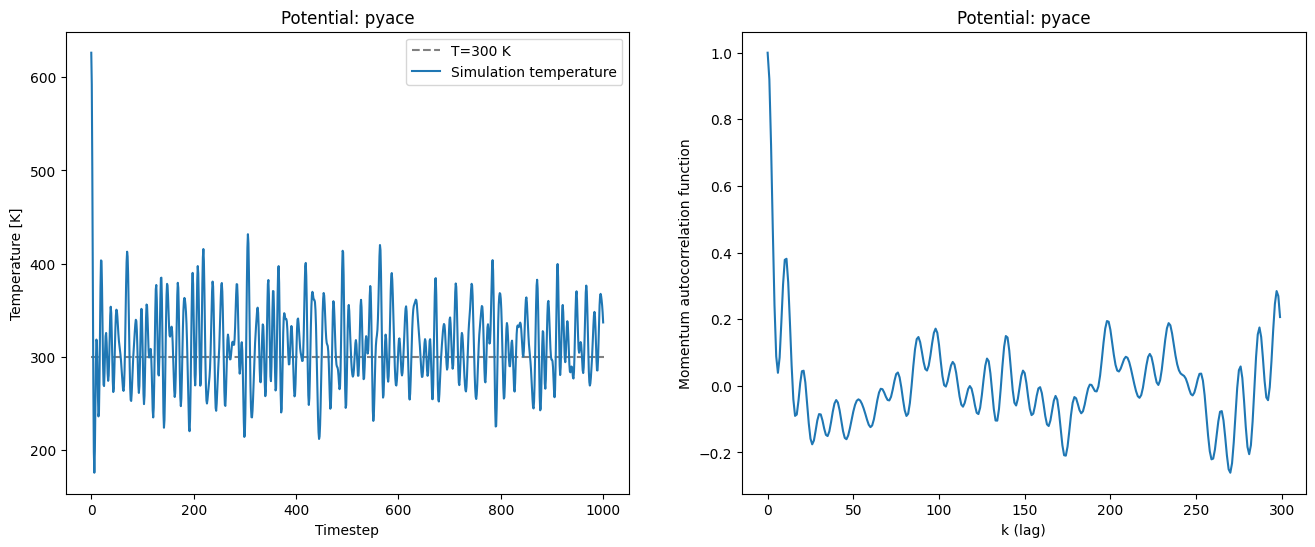

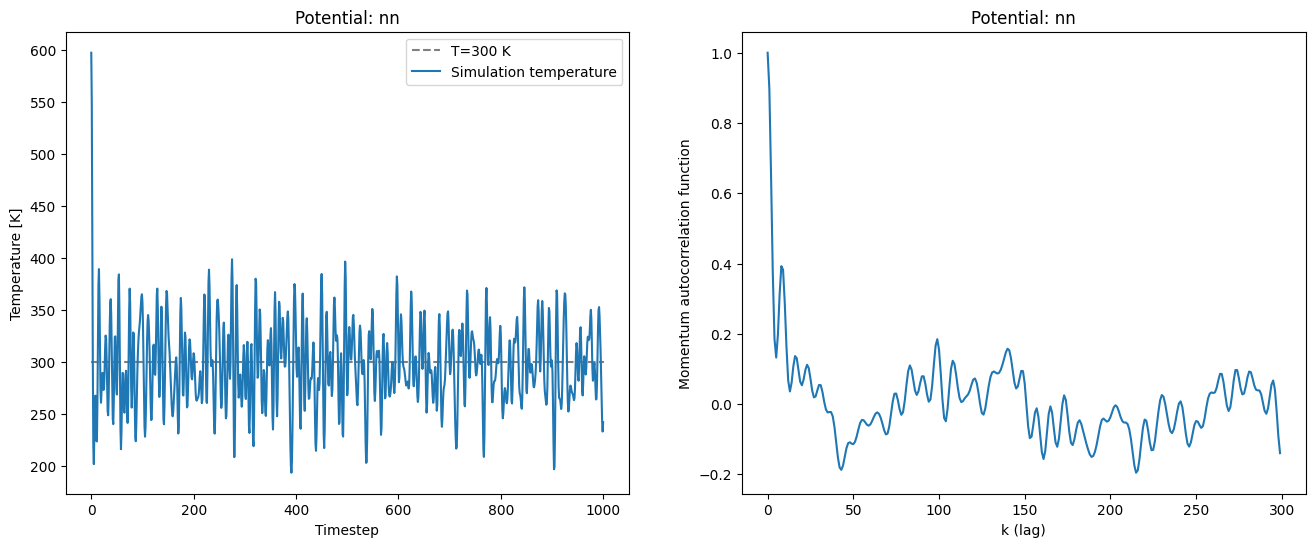

In [290]:
# Plot the results

for name, calc in autocorrelation_test_potentials.items():
    traj_equil_test = Trajectory(f"trajectories_correlations/{name}.traj")
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    temp = np.zeros(len(traj_equil_test))
    for i in range(len(traj_equil_test)):
        temp[i] = traj_equil_test[i].get_temperature()
    
    ax[0].hlines(300, 0, len(traj_equil_test), ls="--", color="gray", label="T=300 K")
    ax[0].plot(temp, label="Simulation temperature")

    ax[0].legend()

    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("Temperature [K]")

    ax[1].plot(autocorrelate_momentum(traj_equil_test)[:300]) # Plot autocorrelation function up to k = 100 to avoid finite size effects

    ax[1].set_xlabel("k (lag)")
    ax[1].set_ylabel("Momentum autocorrelation function")

    ax[0].set_title(f"Potential: {name}")
    ax[1].set_title(f"Potential: {name}")

    plt.show()

In [51]:
# Prepare thermalized systems for analysis
temps = [100, 200, 300, 350] # Temperatures to prepare trajectories for

for temp in temps:
    for name, calc in {"tersoff": tersoff, "pyace": pyace, "nn": nn}.items():
        print(f"[{temp}K] Equilibrating potential {name}")
        equil_system = generate_equilibrated_system(size=(6, 6, 1), T=temp, n_equilibration=2500, timestep=TIMESTEPS[calc], calc=calc, scaling_factors=scaling_factors) # Generate equilibrated system
        
        filename = f"trajectories_vibrations/{name}_{temp}.traj"
        print(f"[{temp}K] Propagating potential {name}")
        propagate_system(atoms=equil_system, n_timestep=10000, timestep=TIMESTEPS[calc], filename=filename) # Propagate system and save trajectory to file


[200K] Equilibrating potential nn
[200K] Propagating potential nn


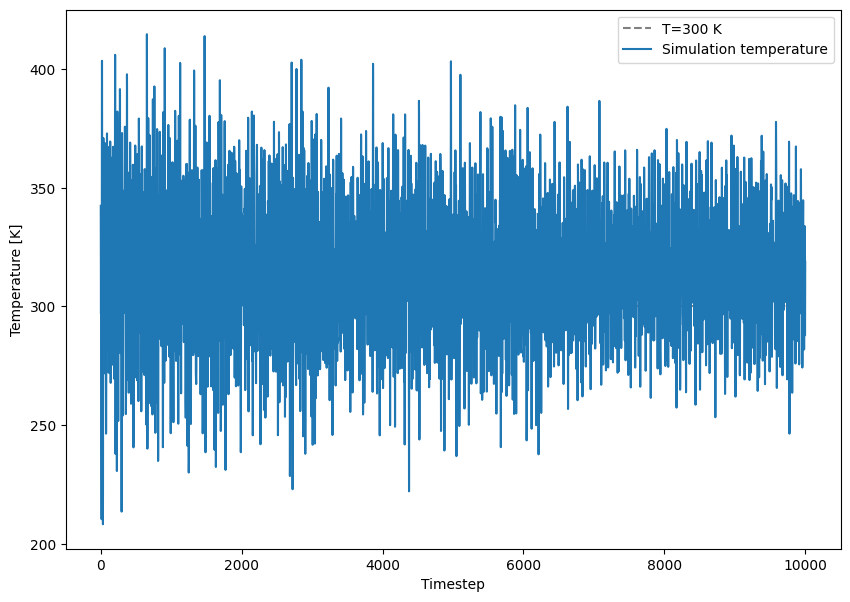

In [66]:
plot_temperature(traj=Trajectory("trajectories_vibrations/pyace_300.traj"), const=300)

In [54]:
temps = [100, 200, 300, 350] # Temperatures to test
potentials = {"tersoff": tersoff, "nn": nn, "pyace": pyace}
#potentials = {"nn": nn}
energies = {tersoff: np.arange(22.0, 27.5, 0.1), pyace: np.arange(20.0, 25.5, 0.1), nn: np.arange(18.0, 24.0, 0.1)}

thresholds = {} # Dict for the results (keys are potentials and temperatures and values are lists of threshold energies)

# Prepare dictionary with empty lists
for name in potentials.keys():
    for temp in temps:
        thresholds[f"{name}@{temp}"] = []

for temp in temps:
    for name, calc in potentials.items():
        traj = Trajectory(f"trajectories_vibrations/{name}_{temp}.traj") # Load the prepared trajectory
        key = f"{name}@{temp}"
        for frame in range(0, len(traj), 100):
            atoms = traj[frame] # Load the frame (we go through the whole trajectory file and always skip 100 frames due to correlations)
            for ekin in energies[calc]:

                prefix = f"[{name}@{temp}K] [{ekin:0.1f}] "
                filename = f"/tmp/trajectories_vibration_ejection.traj" # Temporary file to write trajectories to (we don't need them)

                # We simulate until one simulation ran through completely without the atom having returned (momentum having reversed) before
                # We set timesteps to 80 but are really simulating 80*3=240 timesteps, so we should be fine
                if run_simulation(atoms.copy(), calc, ekin, 80, TIMESTEPS[calc], filename, check_ejected=True, printing=False, ejection_threshold=0) != "not ejected":
                    print(prefix + f"Threshold reached (first ejection)! ({int(frame/100) + 1}/{int(len(traj)/100) + 1})")
                    thresholds[key].append(ekin) # Write threshold to thresholds dictionary
                    break

        if len(thresholds[key]) != 0:
            np.savetxt("results_vibrations/" + key + ".csv", np.array(thresholds[key]), delimiter=",")

[nn@200K] [19.8] Threshold reached (first ejection)! (1/101)
[nn@200K] [19.5] Threshold reached (first ejection)! (2/101)
[nn@200K] [19.6] Threshold reached (first ejection)! (3/101)
[nn@200K] [19.7] Threshold reached (first ejection)! (4/101)
[nn@200K] [19.5] Threshold reached (first ejection)! (5/101)
[nn@200K] [19.7] Threshold reached (first ejection)! (6/101)
[nn@200K] [19.7] Threshold reached (first ejection)! (7/101)
[nn@200K] [20.1] Threshold reached (first ejection)! (8/101)
[nn@200K] [20.0] Threshold reached (first ejection)! (9/101)
[nn@200K] [19.7] Threshold reached (first ejection)! (10/101)
[nn@200K] [19.8] Threshold reached (first ejection)! (11/101)
[nn@200K] [19.7] Threshold reached (first ejection)! (12/101)
[nn@200K] [19.5] Threshold reached (first ejection)! (13/101)
[nn@200K] [19.8] Threshold reached (first ejection)! (14/101)
[nn@200K] [19.5] Threshold reached (first ejection)! (15/101)
[nn@200K] [19.9] Threshold reached (first ejection)! (16/101)
[nn@200K] [19.2] 

In [55]:
def load_results(potential : str, temp : float) -> np.ndarray:
    """
    Loads a specific result for the simulation of the threshold energy of a
    thermalized system.

    Parameters
    ----------
    potential : str
        The name of the potential used in the simulation

    temp : float
        The temperature used in the simulation

    Returns
    -------
    result : np.ndarray
        The first ejection energies obtained in the simulation
    """
    path = f"results_vibrations/{potential}@{temp}.csv"
    assert os.pyth.isfile(path), f"Result {path} does not exist."
    return np.loadtxt(path, delimiter=",")

def load_all_results() -> dict:
    """
    Load all the results found in results_vibrations/ and return it as a dict

    Returns
    -------
    loaded_results : dict
        A dictionary containing all the results, like the one produced in the simulation that
        generated the .csv files

        Keys: potential@temperature
        Values: np.ndarray of the obtained threshold energies

    potentials : list
        The names of the potentials that were loaded

    temps : list
        The temperatures that were loaded
    """
    pattern = re.compile(r"^[a-zA-Z0-9\s]+@[0-9]+(?:\.[0-9]+)?\.csv$", re.IGNORECASE)
    files = [f for f in os.listdir("results_vibrations") if os.path.isfile(os.path.join("results_vibrations", f)) and pattern.match(f)]

    loaded_results = {}
    for file in files:
        loaded_results[file[:-4]] = np.loadtxt(os.path.join("results_vibrations", file), delimiter=",")

    potentials = list(set([name.split("@")[0] for name in loaded_results.keys()]))
    temps = list(set([float(name.split("@")[1]) if "." in name.split("@")[1] else int(name.split("@")[1]) for name in loaded_results.keys()]))

    return loaded_results, potentials, temps

In [56]:
def normal(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*np.power((x - mu)/sigma, 2))

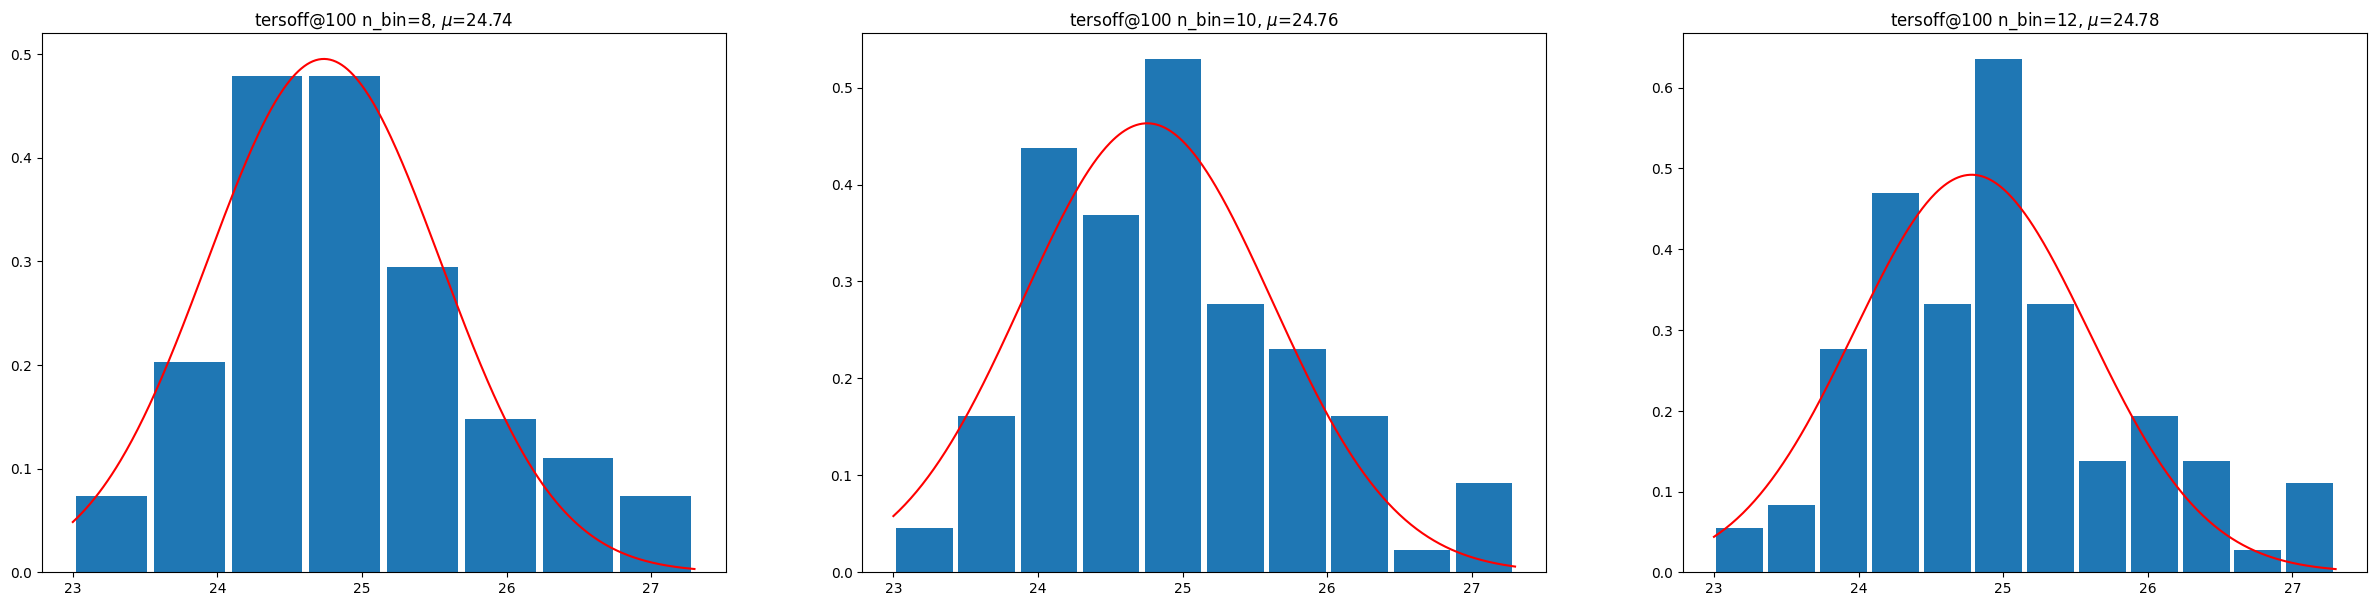

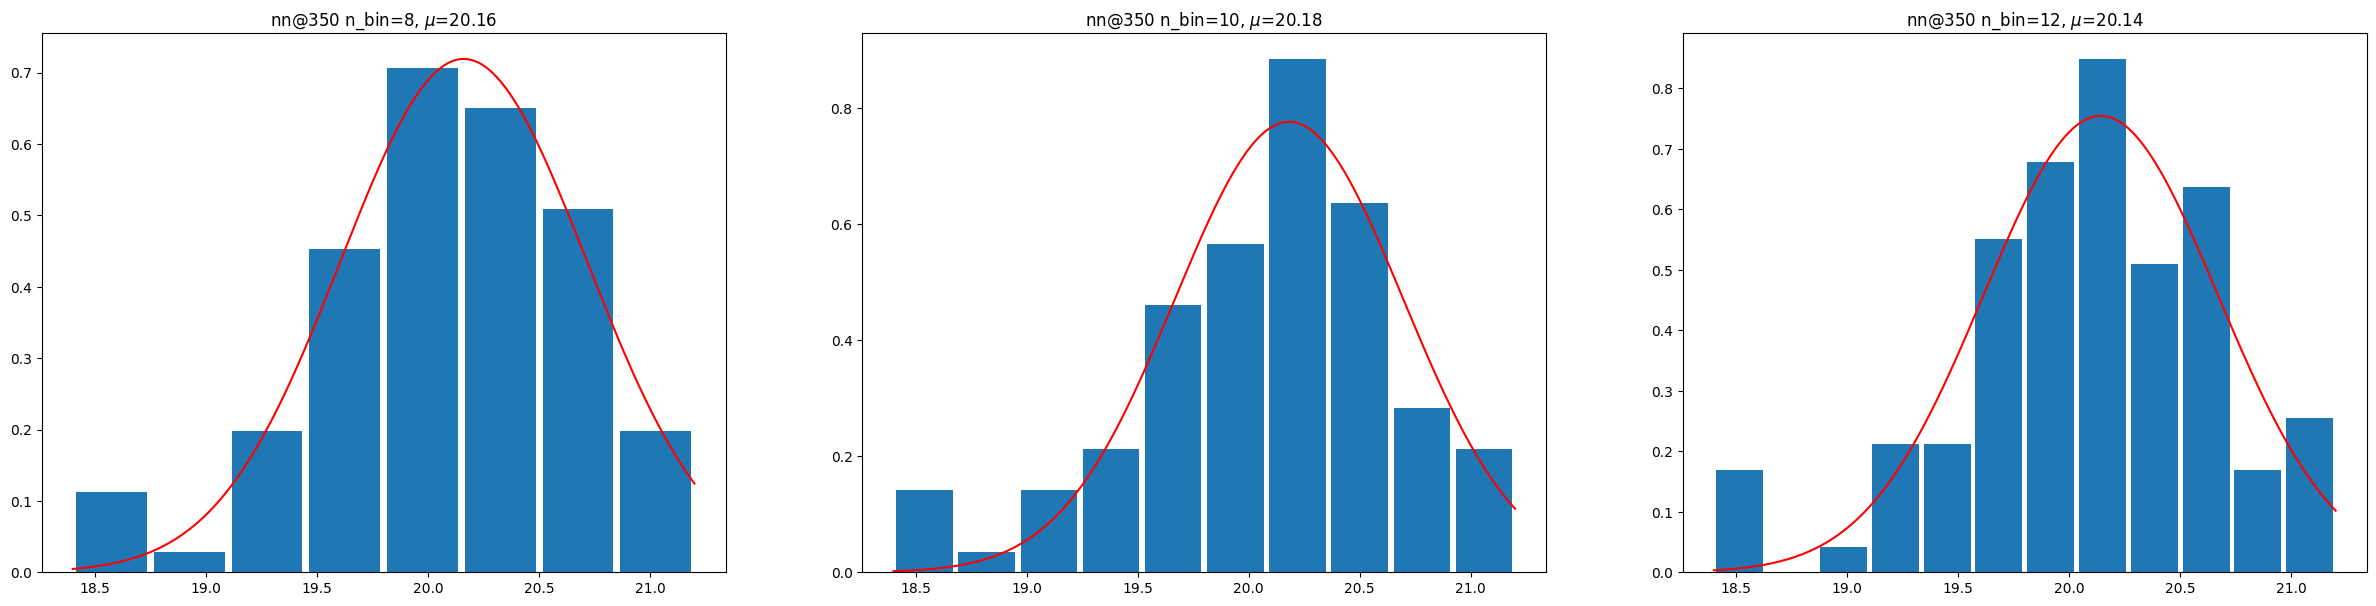

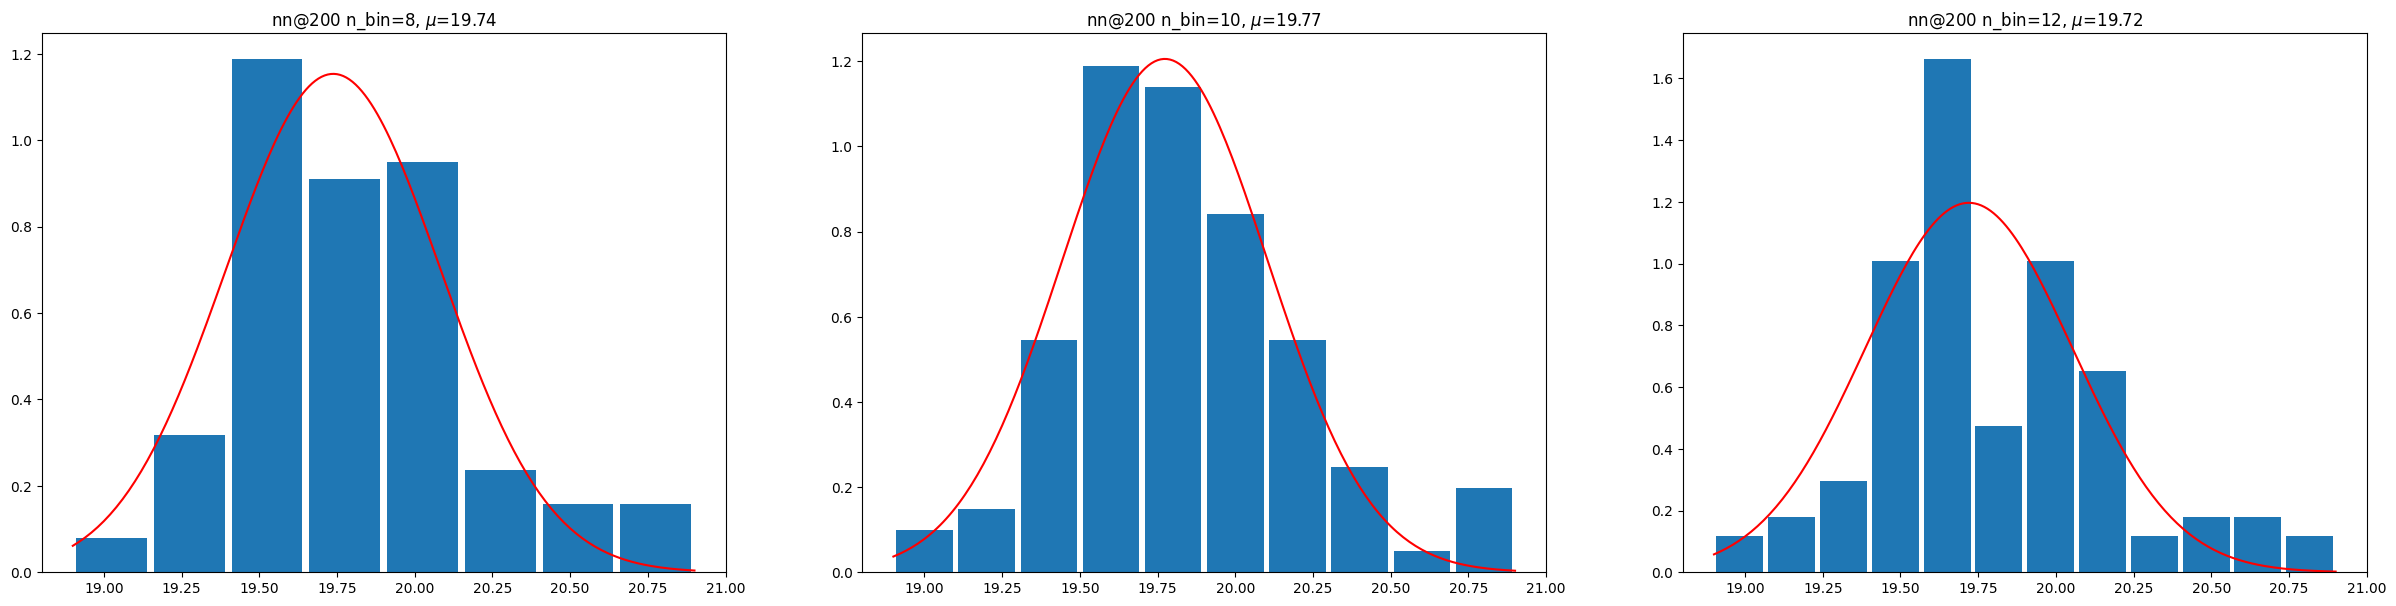

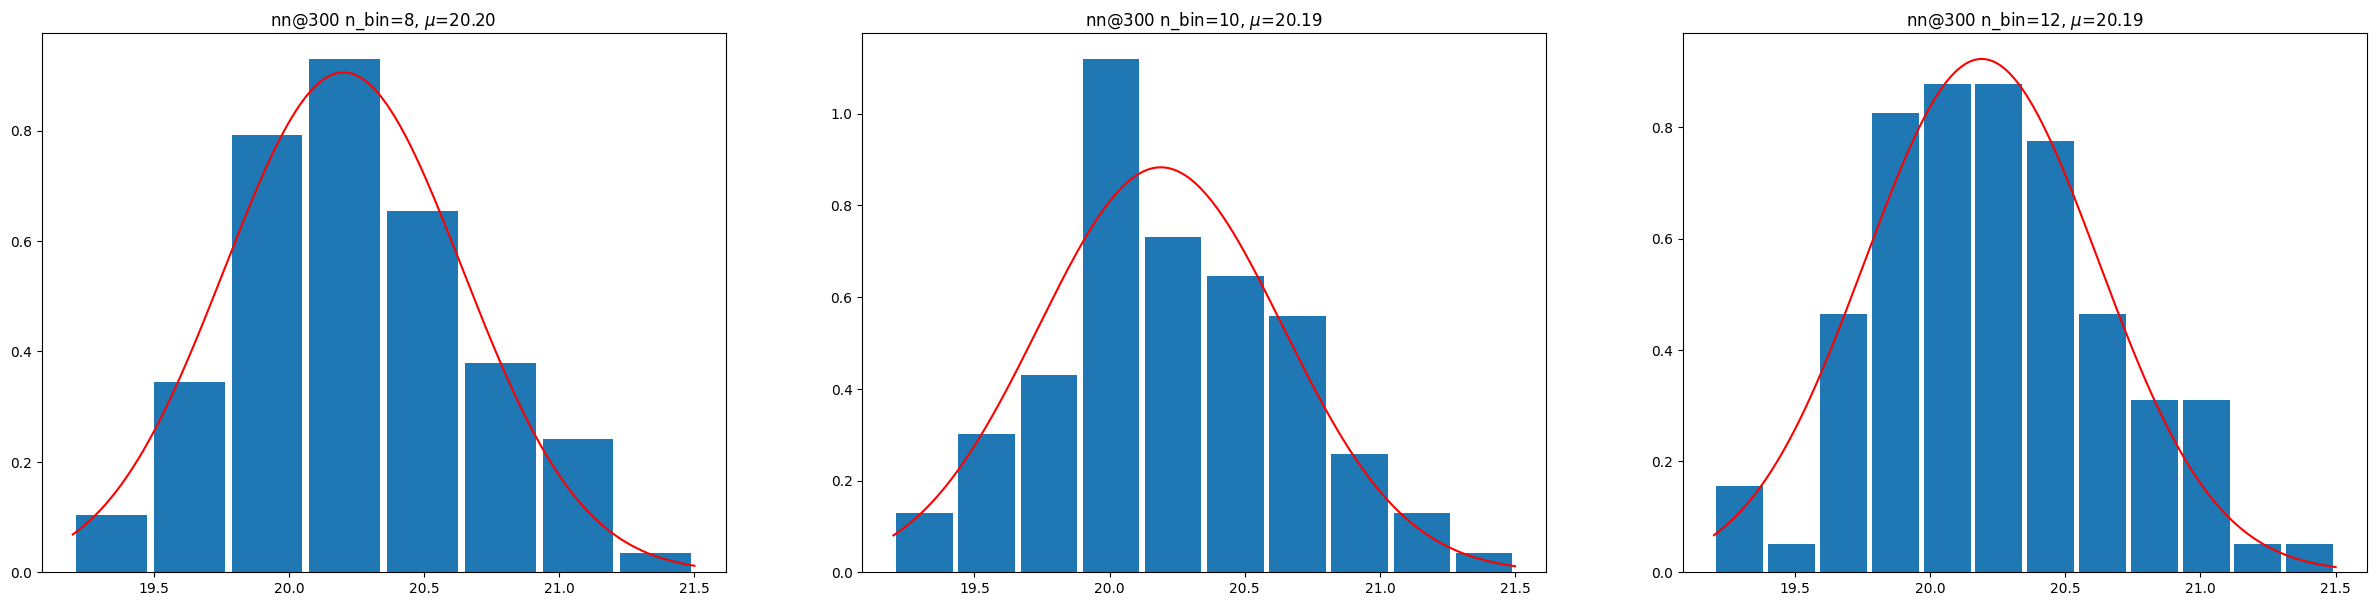

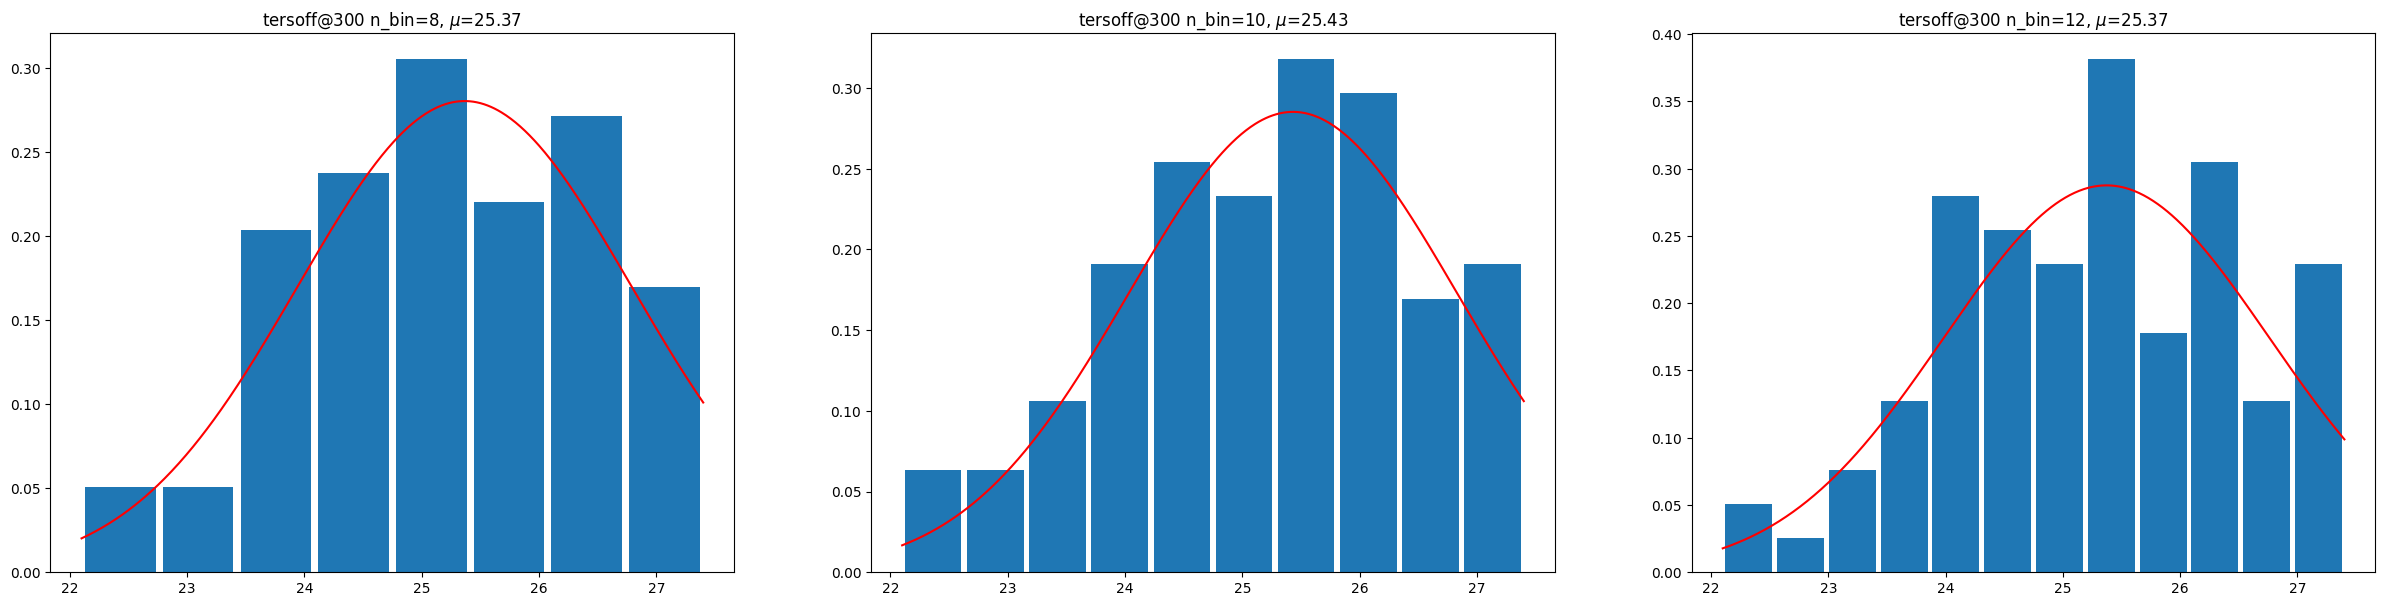

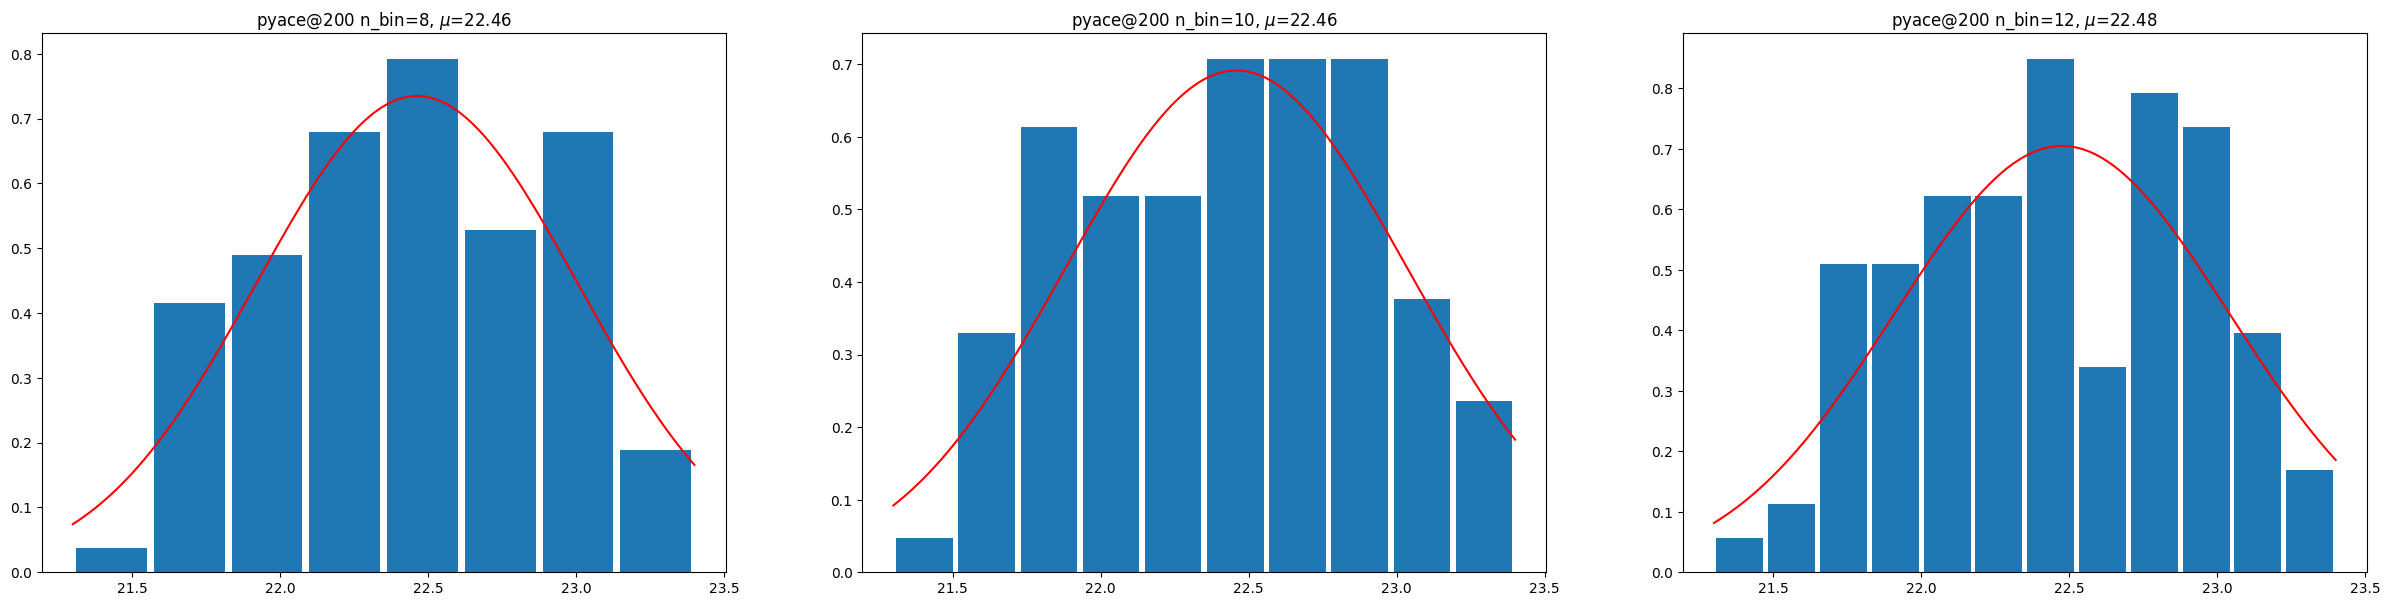

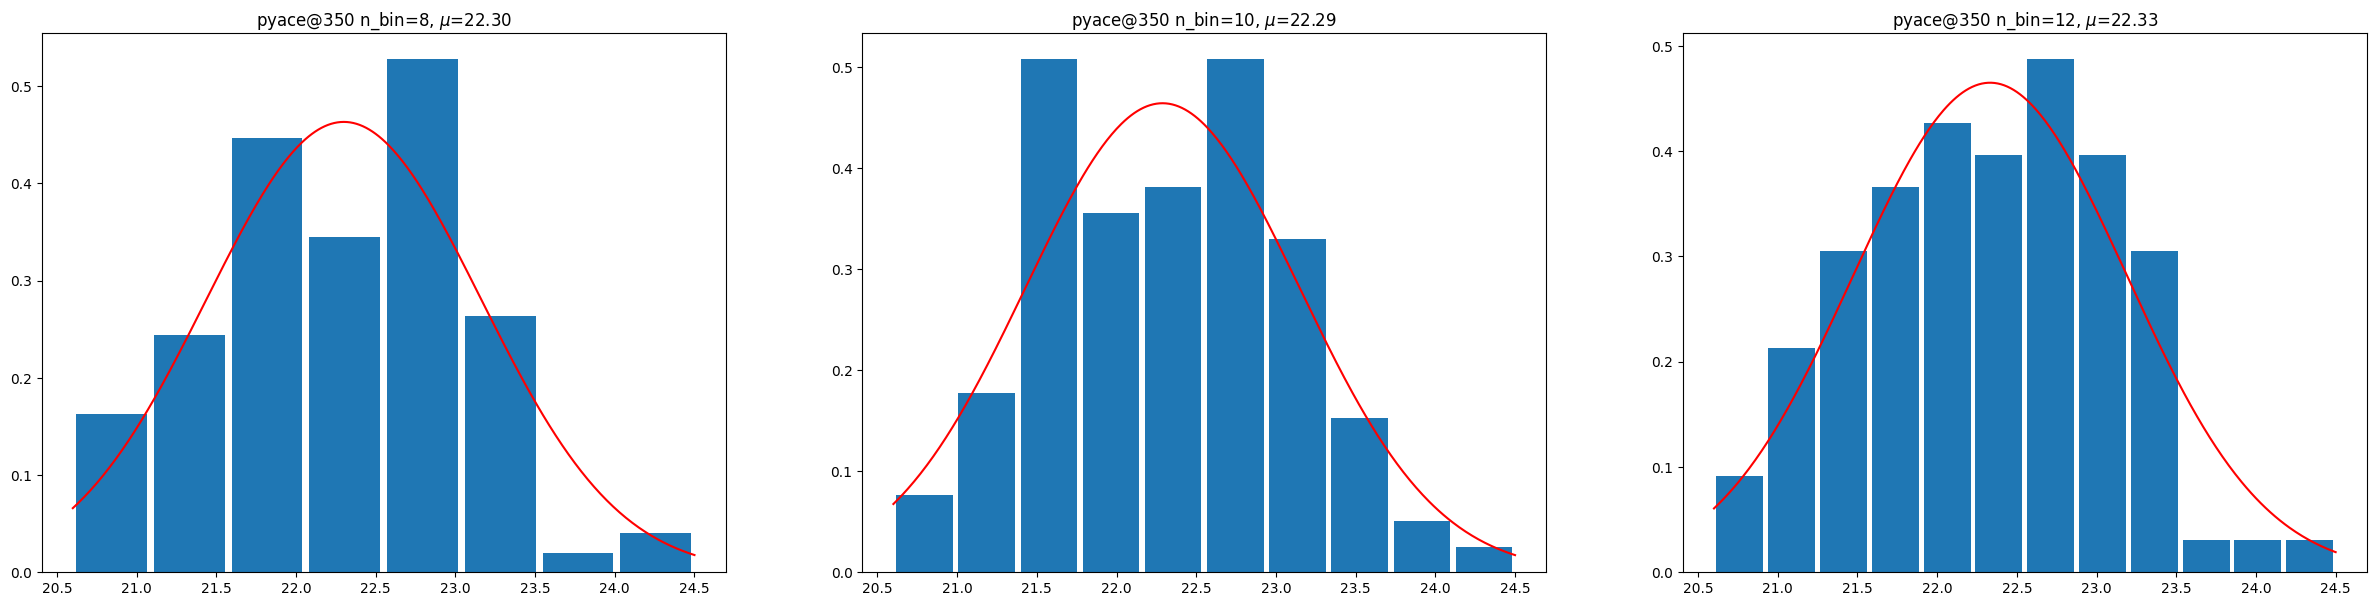

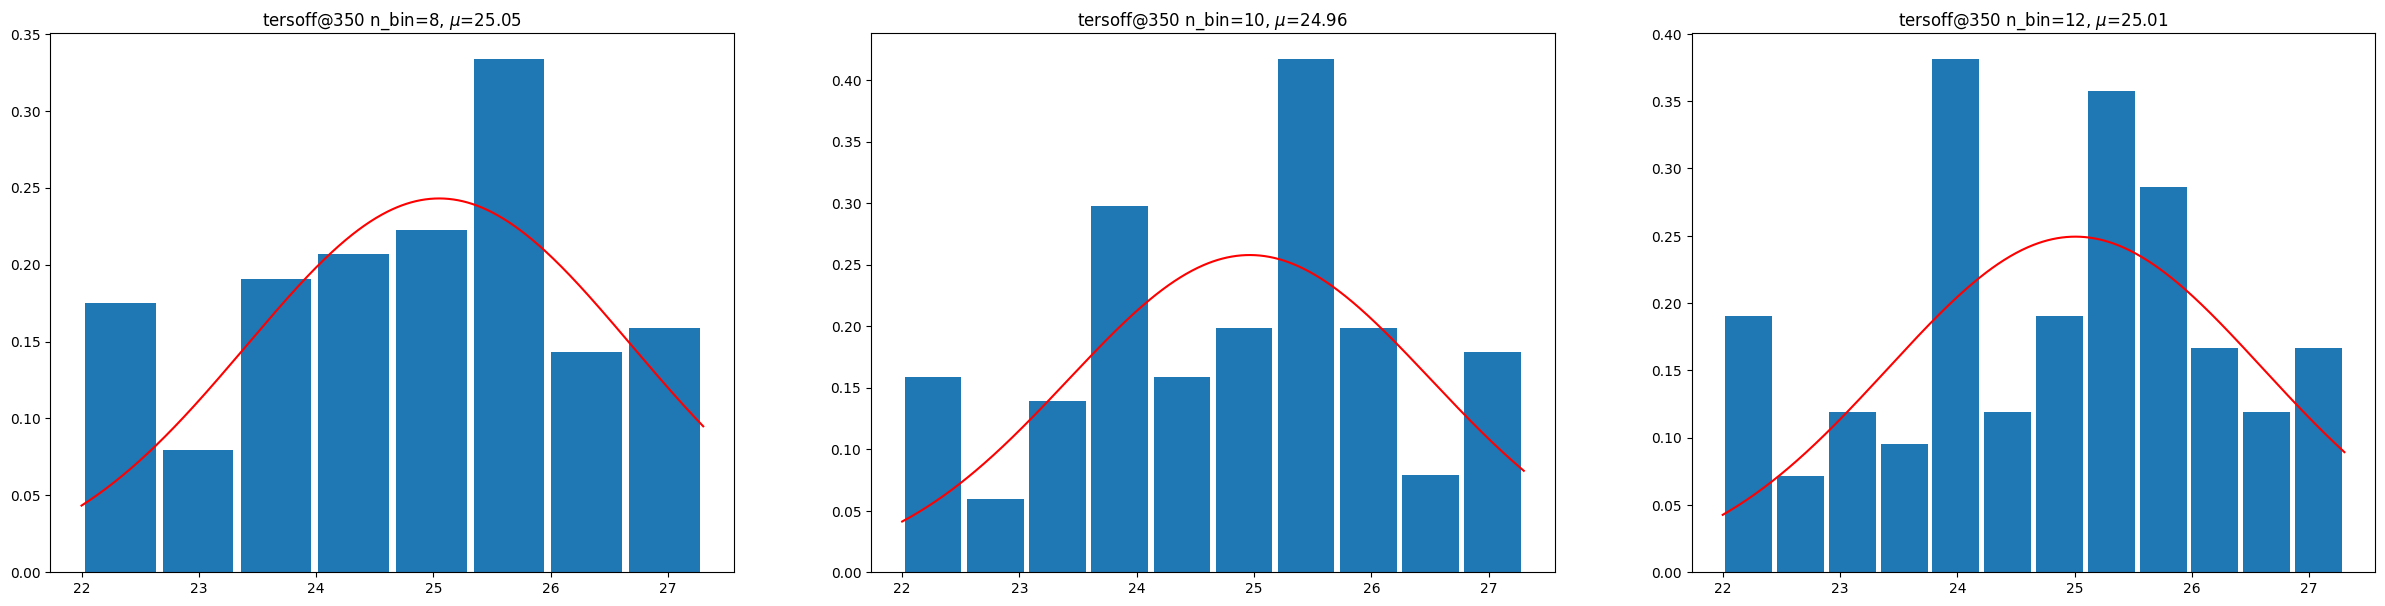

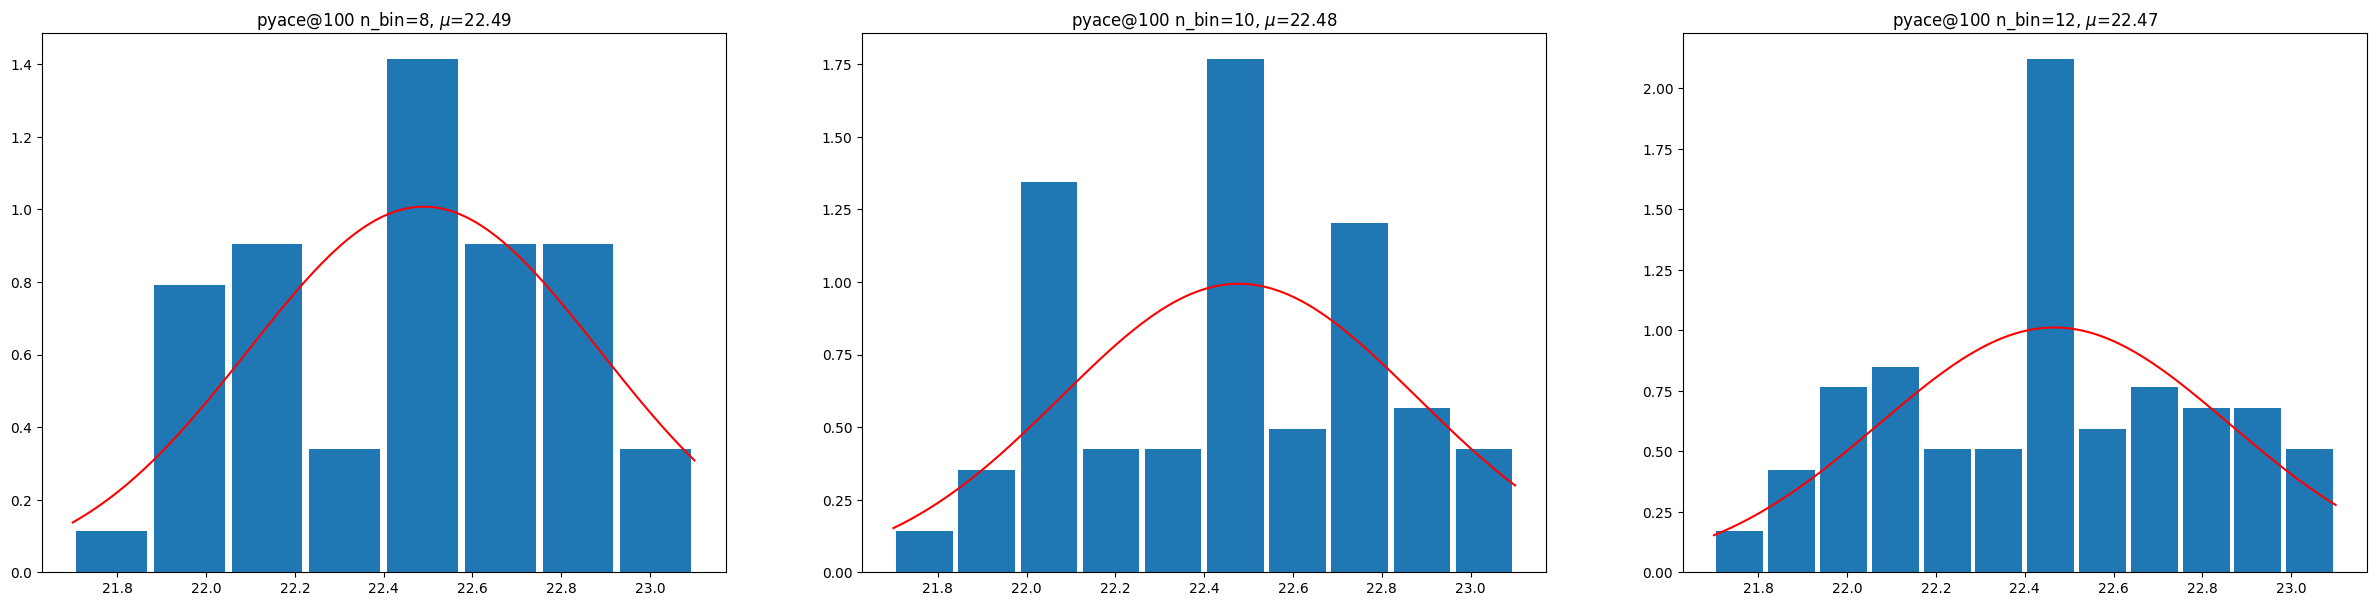

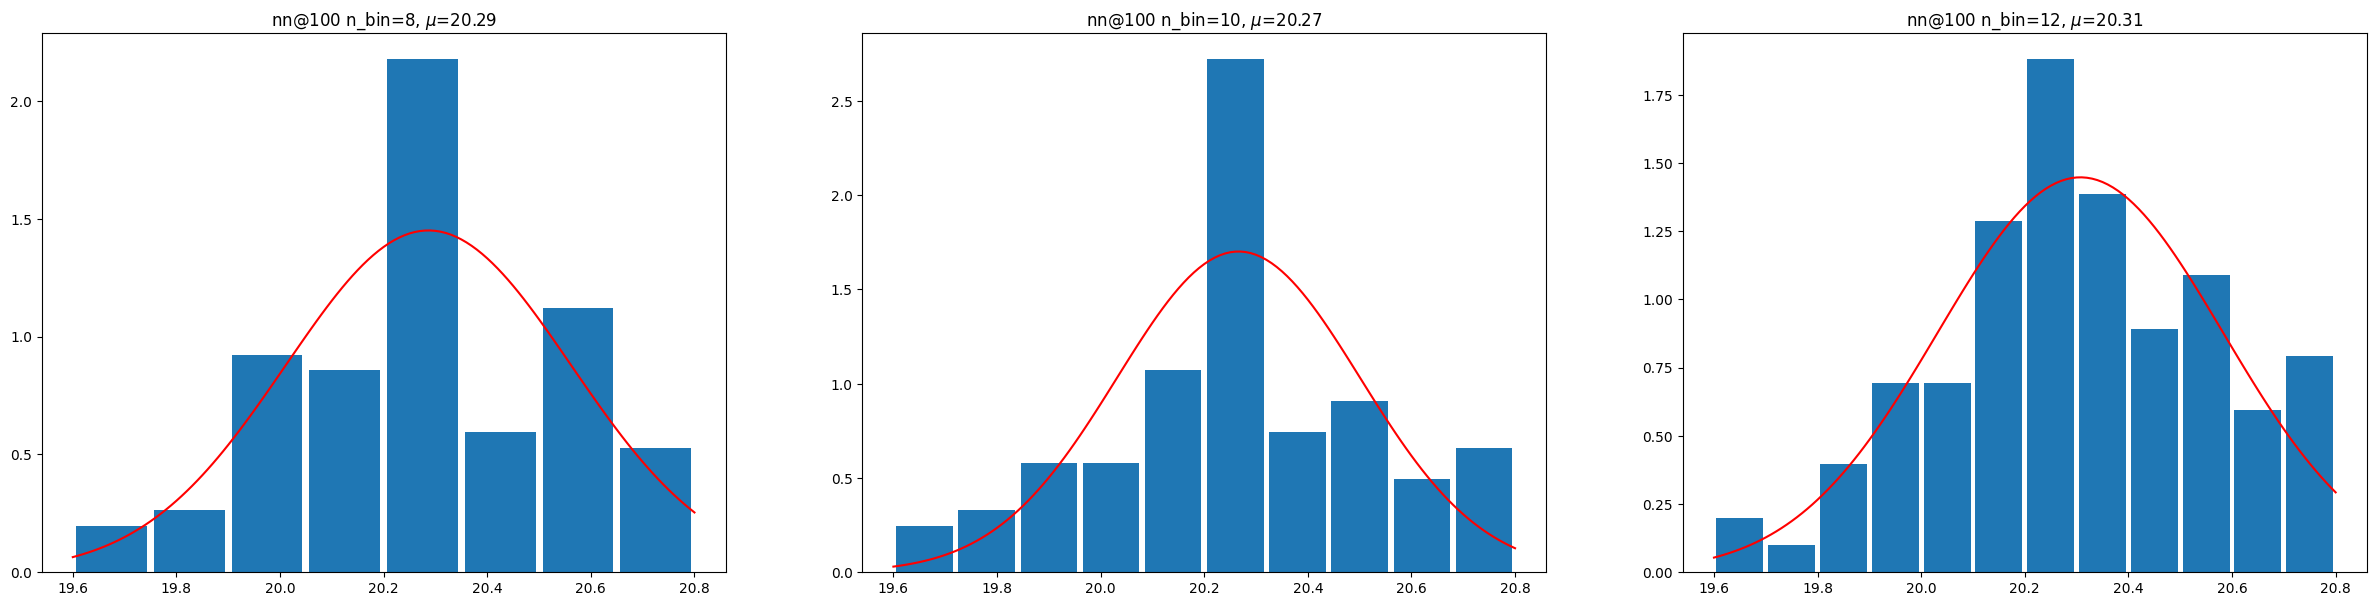

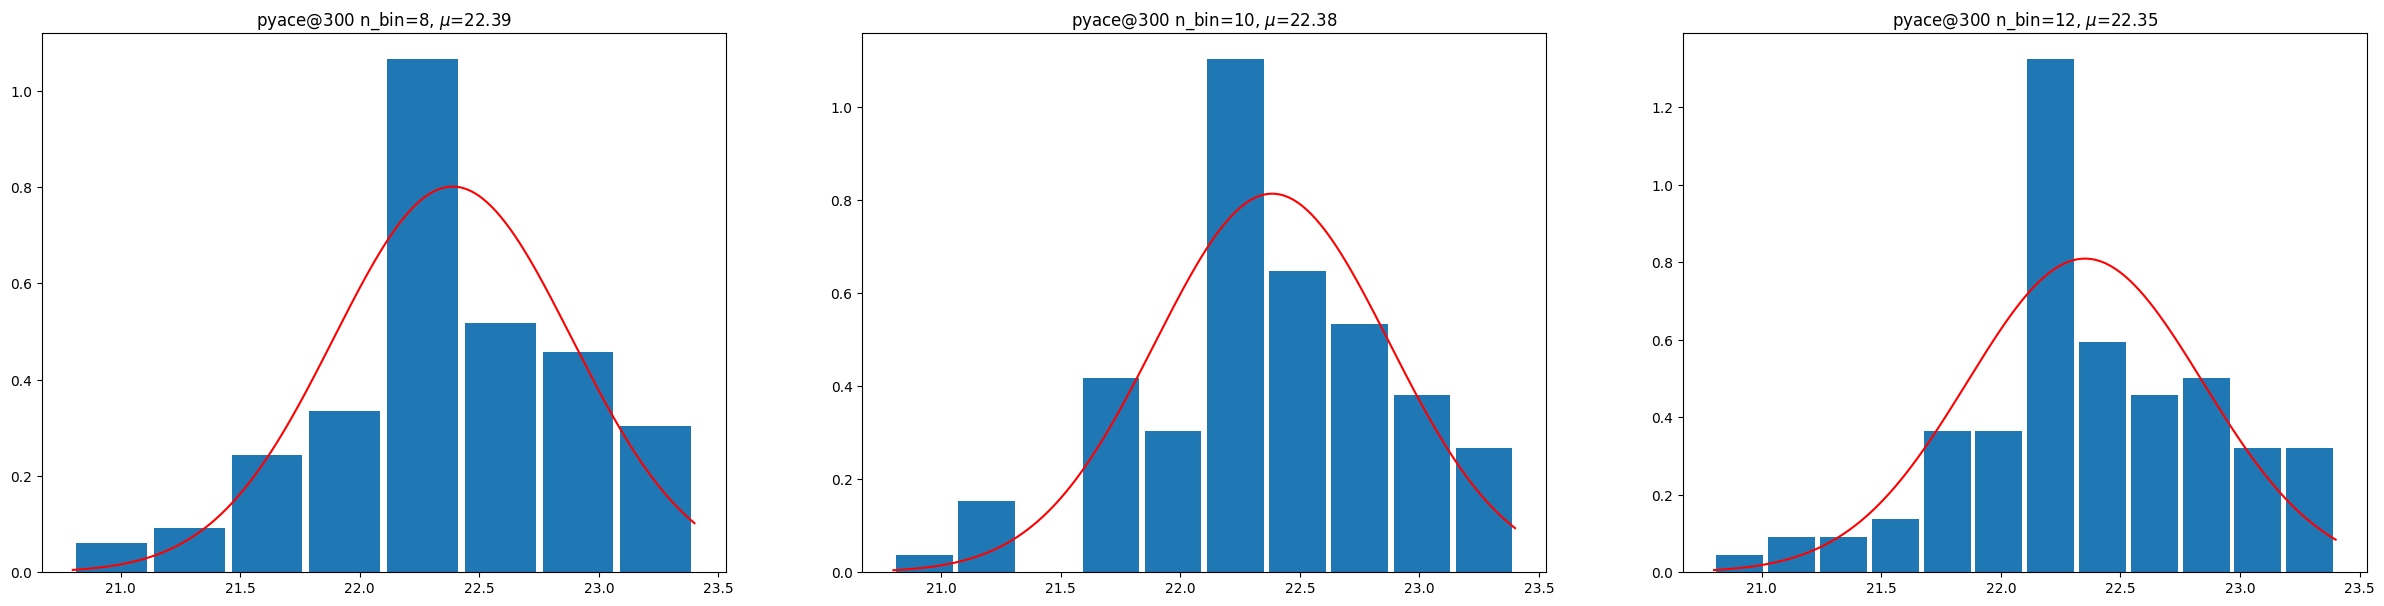

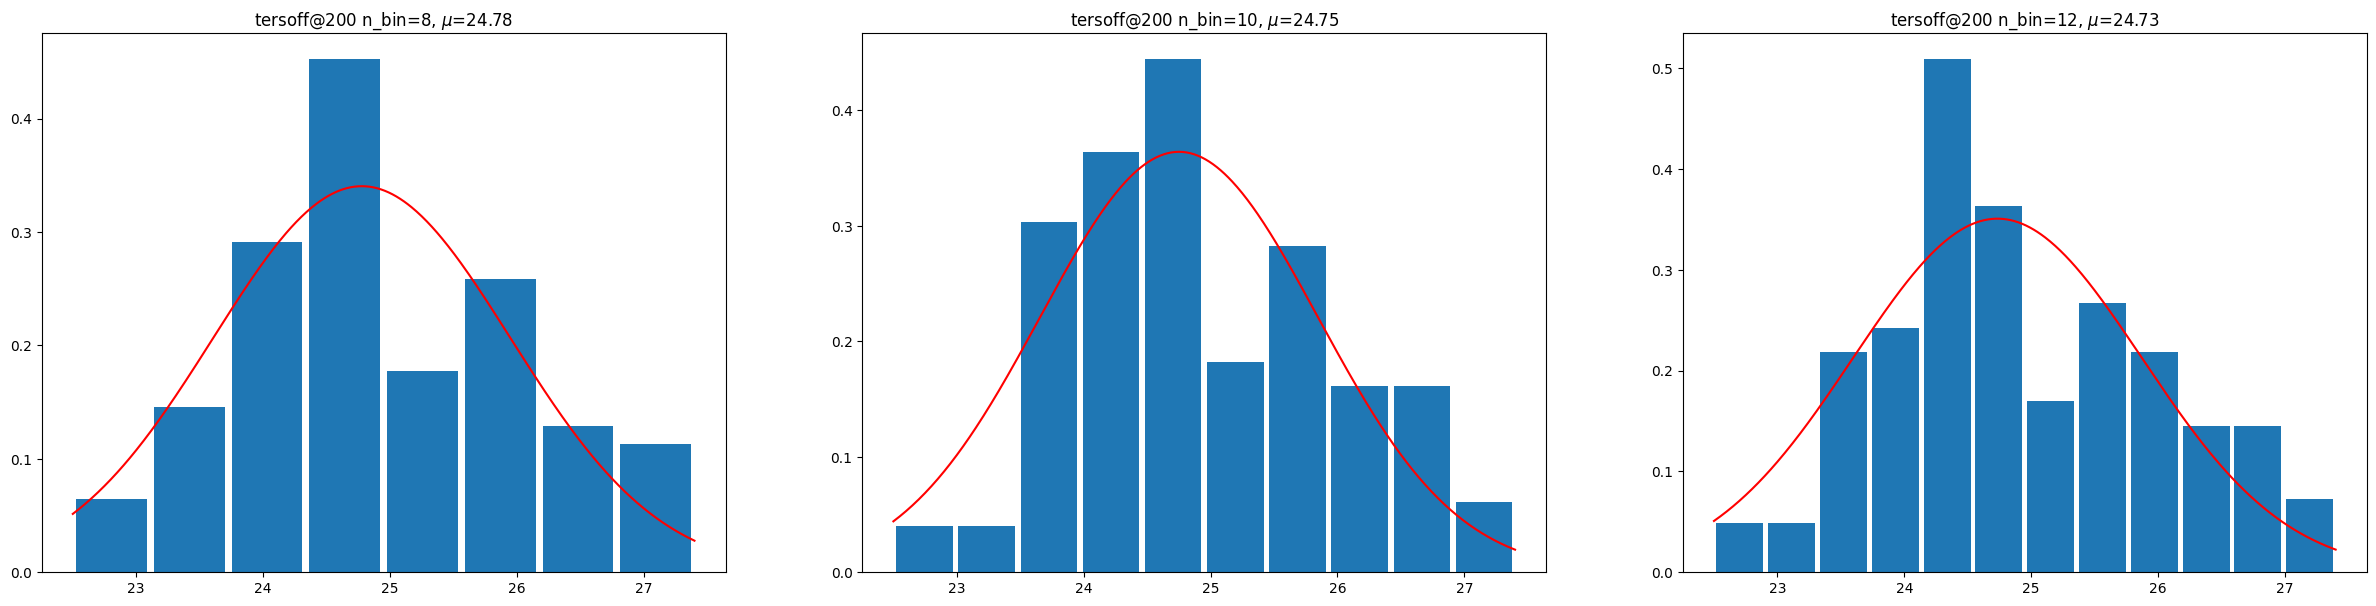

In [57]:
# Analyzation code for the results of the thermalized threshold energies, deciding on a number of bins to use

loaded_results, potentials, temps = load_all_results()

n_bins = [8, 10, 12]

for key, result in loaded_results.items():
    fig, ax = plt.subplots(1, len(n_bins), figsize=(10*len(n_bins), 7))
    for i, n_bin in enumerate(n_bins):
        pdf, bins = np.histogram(result, density=True, bins=n_bin)
        bin_centers = (bins[1:] + bins[:-1])/2

        bin_width = (bins[1:] - bins[:-1])[0]

        p0 = [np.mean(result), np.std(result)]

        popt, pcov = sc.optimize.curve_fit(normal, bin_centers, pdf, p0=p0)
        mu, sigma = popt[0], popt[1]

        x = np.arange(bins[0], bins[-1], 0.01)

        ax[i].bar(bin_centers, pdf, align="center", width=bin_width/1.1)
        ax[i].plot(x, normal(x, *popt), color="red")

        ax[i].set_title(f"{key} n_bin={n_bin}, $\mu$={mu:0.2f}")

    plt.show()

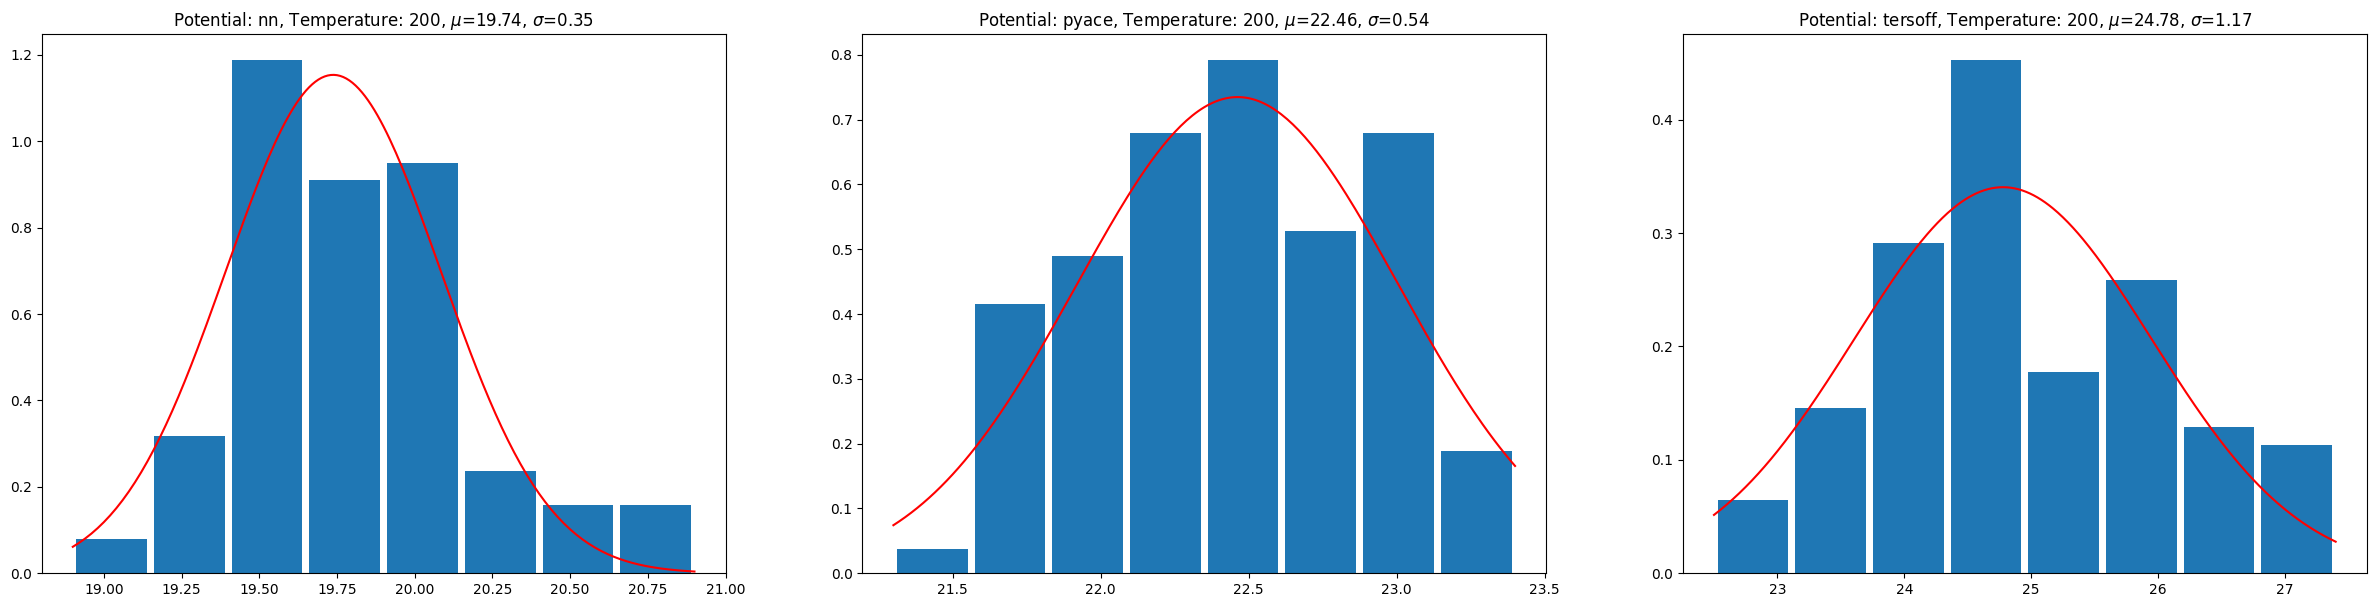

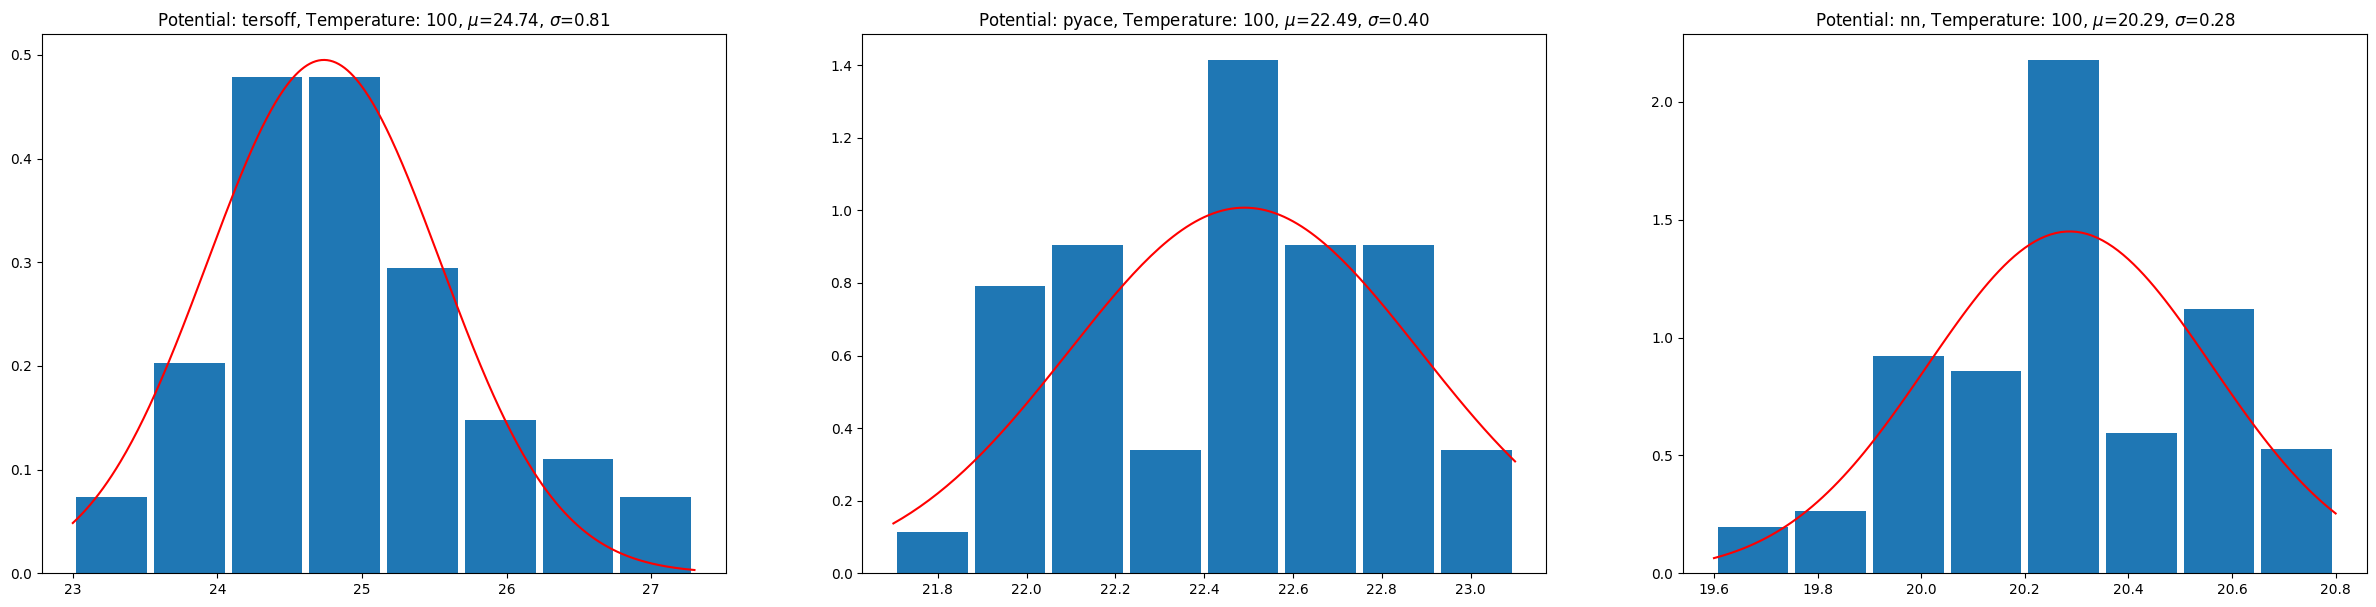

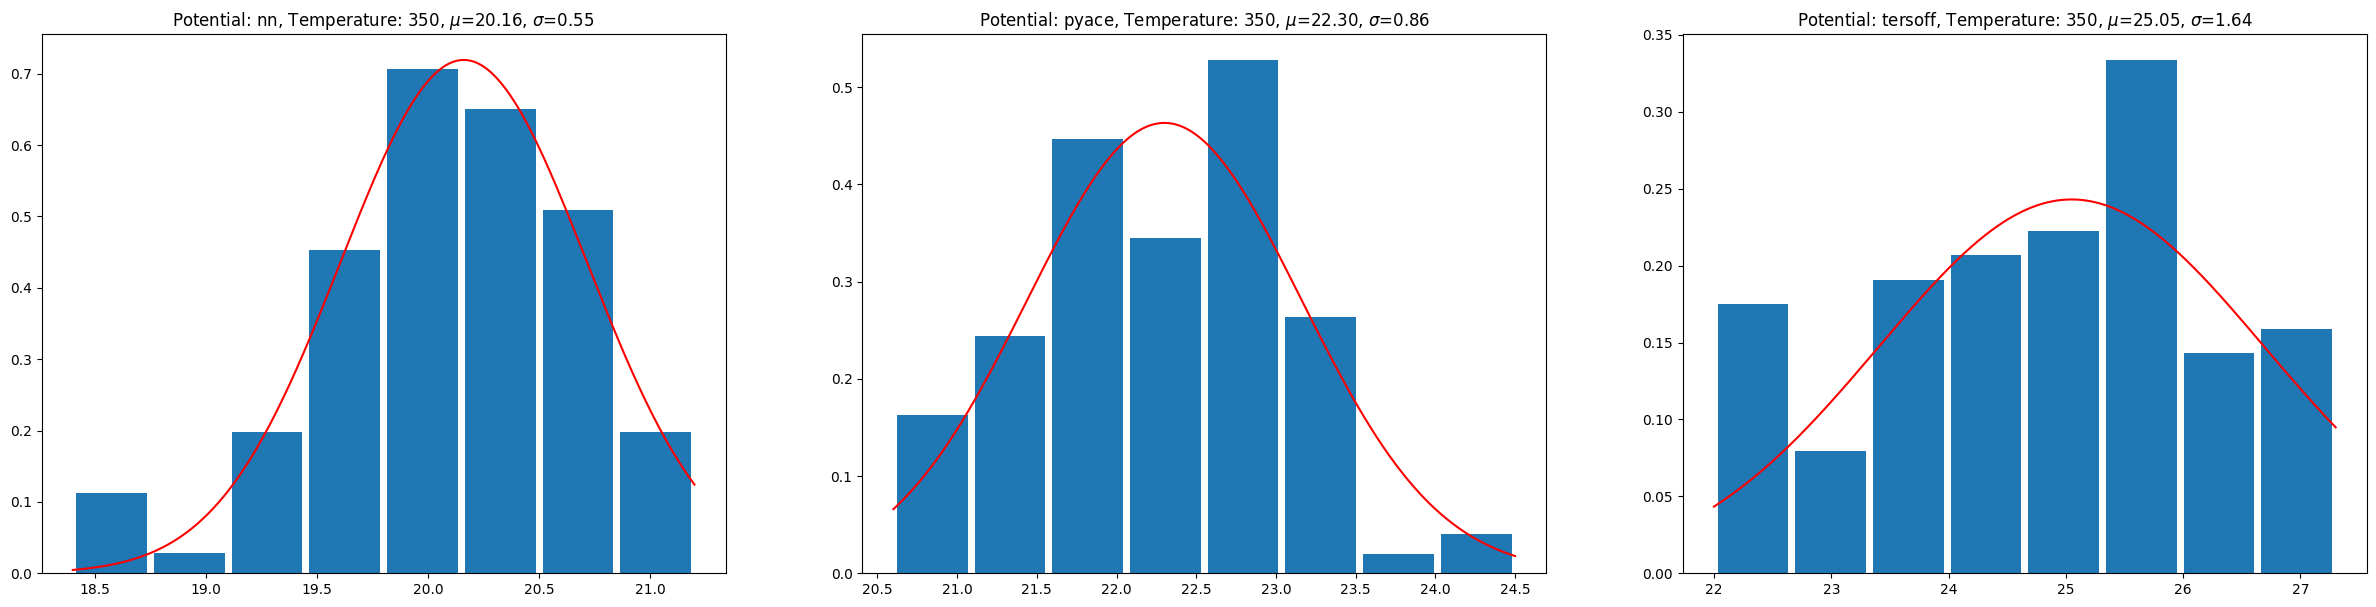

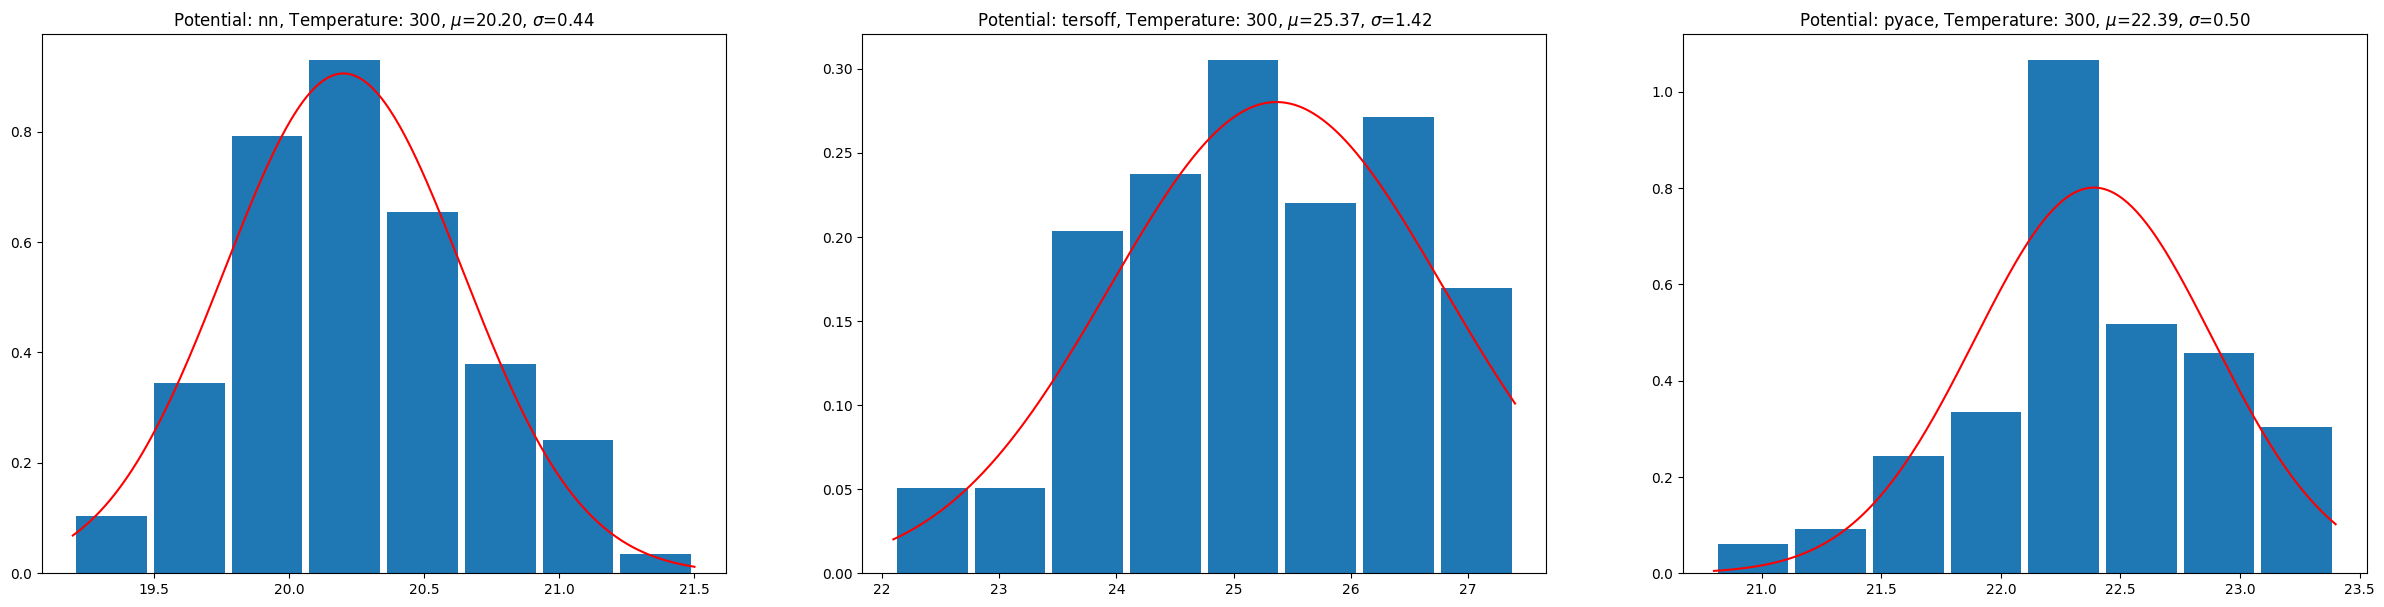

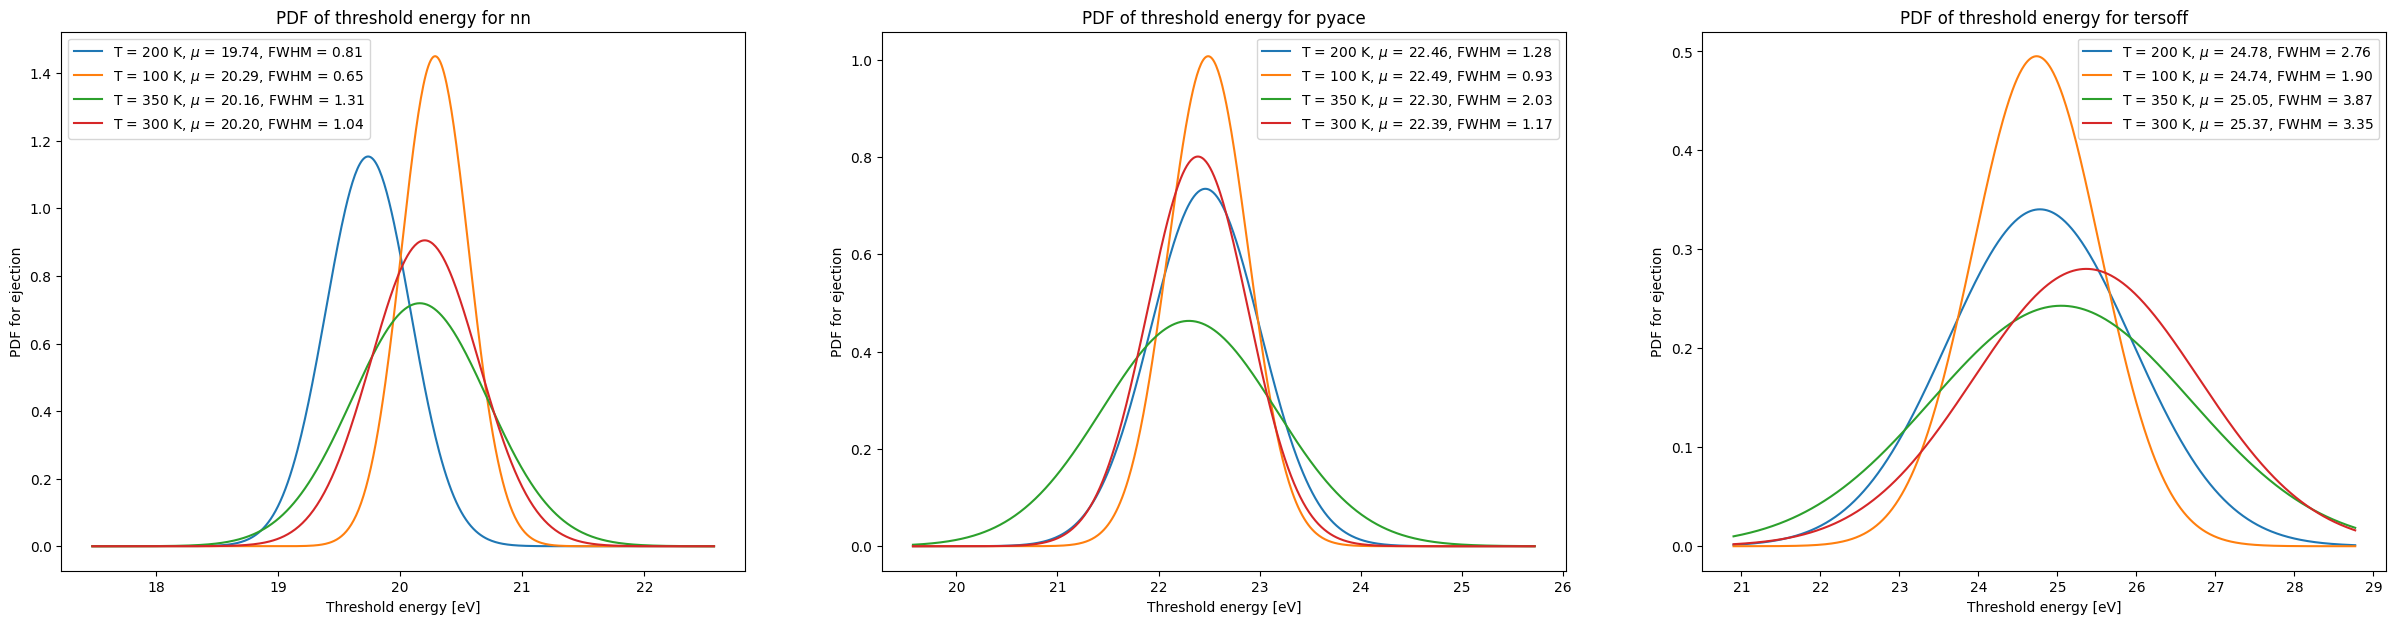

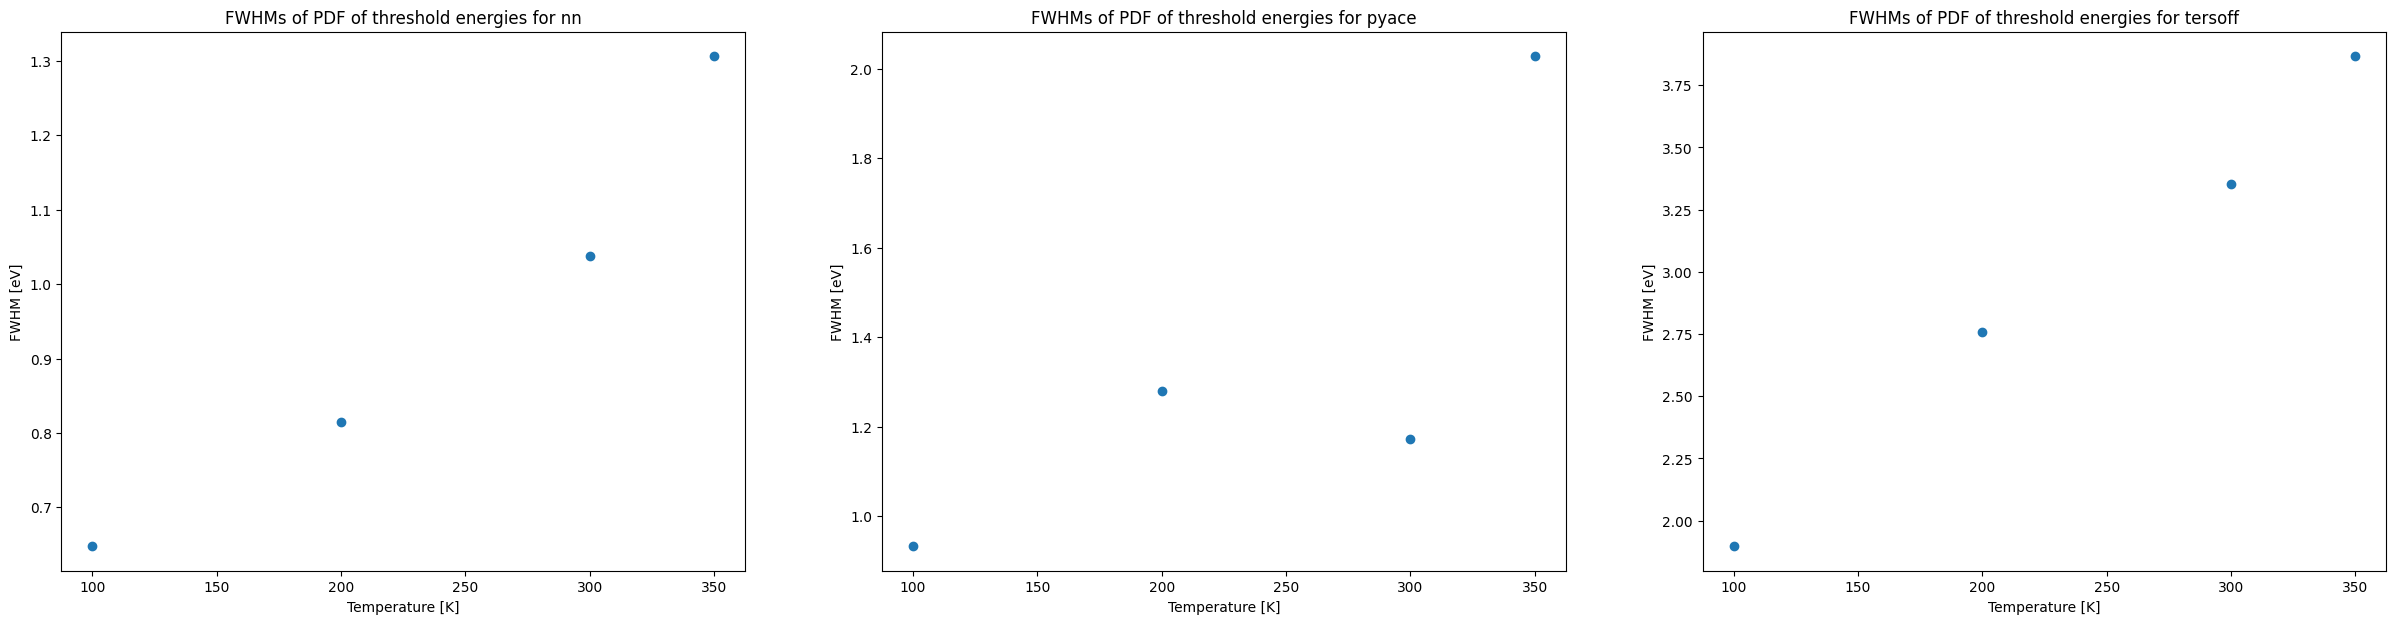

In [58]:
# Doing the plots separated by temperature for 8 bins per potential with histogram

loaded_results, potentials, temps = load_all_results()

temp_results = {temp: {key.split("@")[0]: loaded_results[key] for key in loaded_results.keys() if int(key.split("@")[1]) == temp} for temp in temps}

n_bin = 8

fit_params = {potential: {} for potential in potentials}

for temp in temp_results.keys():
    n_potentials = len(temp_results[temp].keys())
    fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))
    for i, potential in enumerate(temp_results[temp]):
        result = temp_results[temp][potential]
        pdf, bins = np.histogram(result, density=True, bins=n_bin)
        bin_centers = (bins[1:] + bins[:-1])/2

        bin_width = (bins[1:] - bins[:-1])[0]

        p0 = [np.mean(result), np.std(result)]

        popt, pcov = sc.optimize.curve_fit(normal, bin_centers, pdf, p0=p0)
        mu, sigma = popt[0], popt[1]

        fit_params[potential][temp] = (popt, bins[0], bins[-1])

        x = np.arange(bins[0], bins[-1], 0.01)

        ax[i].bar(bin_centers, pdf, align="center", width=bin_width/1.1)
        ax[i].plot(x, normal(x, *popt), color="red")

        ax[i].set_title(f"Potential: {potential}, Temperature: {temp}, $\mu$={mu:0.2f}, $\sigma$={sigma:0.2f}")

    plt.show()

# PDFs for different temperatures per potential

n_potentials = len(fit_params.keys())

fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))

for i, potential in enumerate(fit_params.keys()):
    x_min, x_max = 1000, 0
    for temp in fit_params[potential].keys():
        params = fit_params[potential][temp]
        if params[1] < x_min:
            x_min = params[1]
        if params[2] > x_max:
            x_max = params[2]
    for temp in fit_params[potential].keys():
        params = fit_params[potential][temp]
        FWHM = 2.355*params[0][1]

        x = np.arange(0.95*x_min, 1.05*x_max, 0.01)

        ax[i].plot(x, normal(x, *params[0]), label=f"T = {temp} K, $\mu$ = {params[0][0]:0.2f}, FWHM = {FWHM:0.2f}")
    
    ax[i].set_title(f"PDF of threshold energy for {potential}")
    ax[i].legend()
    ax[i].set_xlabel("Threshold energy [eV]")
    ax[i].set_ylabel("PDF for ejection")

plt.show()

# FWHMs per potential as a function of temperature

fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))

for i, potential in enumerate(fit_params.keys()):
    FWHMs = []
    for temp in fit_params[potential].keys():
        params = fit_params[potential][temp]
        FWHMs.append(2.355*params[0][1])

    ax[i].scatter(list(fit_params[potential].keys()), FWHMs)
    
    ax[i].set_title(f"FWHMs of PDF of threshold energies for {potential}")
    ax[i].set_xlabel("Temperature [K]")
    ax[i].set_ylabel("FWHM [eV]")

plt.show()

## References

[1] Gross, R. and Marx, A. (2022) Festkörperphysik. 4., akt. Aufl. München Wien: De Gruyter Oldenbourg.

[2] Susi, T., Meyer, J. C., & Kotakoski, J. (2019). Quantifying transmission electron microscopy irradiation effects using two-dimensional materials. Nature Reviews Physics, 1(6), 397–405. doi:10.1038/s42254-019-0058-y